# Cell 1: Imports and Setup

This cell imports all necessary libraries for the algorithmic trading bot.

Key Components:
- Core libraries: pandas, numpy, datetime
- ML libraries: sklearn, xgboost, tensorflow
- Trading: alpaca-py
- Utilities: tqdm for progress, logging for monitoring
- Visualization: matplotlib, seaborn

Setup:
- Suppress warnings for clean output
- Configure matplotlib for inline plotting
- Set random seeds for reproducible results

In [4]:
# ============================================================================
# ALGORITHMIC TRADING BOT - CELL 1: IMPORTS AND SETUP
# ============================================================================

# Core Libraries
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import os
import pickle
import logging
from datetime import datetime, timedelta
from dataclasses import dataclass
from typing import Dict, List, Optional, Tuple, Any
from abc import ABC, abstractmethod
import json

# Environment and Configuration
from dotenv import load_dotenv
load_dotenv()

# Trading API (alpaca-py)
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import MarketOrderRequest, GetOrdersRequest
from alpaca.trading.enums import OrderSide, TimeInForce

# Machine Learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb

# Deep Learning (TensorFlow/Keras will be imported only in the LSTM cell)
# import tensorflow as tf
# from tensorflow.keras.models import Sequential, load_model
# from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.callbacks import EarlyStopping
# tf.get_logger().setLevel('ERROR')  # Suppress TF warnings

# Technical Analysis
import talib

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
import ipywidgets as widgets
%matplotlib inline

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# Random seeds for reproducibility
np.random.seed(42)
# tf.random.set_seed(42)  # Only set in LSTM cell if needed

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[
        logging.FileHandler('bot.log'),
        logging.StreamHandler()
    ]
)

logger = logging.getLogger(__name__)

print("All imports loaded successfully!")
# print(f"TensorFlow version: {tf.__version__}")  # Only print in LSTM cell
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

All imports loaded successfully!
Pandas version: 2.1.4
NumPy version: 1.26.2


# Cell 2: Configuration

This cell defines all configuration parameters using a dataclass for clean organization.

Key Features:
- Environment variable loading with python-dotenv
- Risk management parameters
- Trading universe (15 liquid symbols)
- ML model parameters
- Operational settings

Security:
- API credentials loaded from environment variables
- Paper trading mode enabled by default

In [5]:
# ============================================================================
# CELL 2: CONFIGURATION
# ============================================================================

@dataclass
class TradingConfig:
    """Configuration class for algorithmic trading bot"""
    
    # API Configuration
    ALPACA_API_KEY: str = os.getenv('ALPACA_API_KEY')
    ALPACA_SECRET_KEY: str = os.getenv('ALPACA_SECRET_KEY')
    ALPACA_BASE_URL: str = 'https://paper-api.alpaca.markets/v2'  # Paper trading
    
    # Portfolio Settings
    INITIAL_CAPITAL: float = 100000.0  # $100K paper trading
    MAX_POSITION_PCT: float = 0.15     # 15% per symbol
    MAX_TOTAL_EXPOSURE: float = 0.90   # 90% invested max
    MIN_POSITION_VALUE: float = 1000   # Minimum $1K position
    
    # Risk Management
    STOP_LOSS: float = 0.03            # 3% stop loss
    TAKE_PROFIT: float = 0.07          # 7% take profit
    MAX_DAILY_LOSS_PCT: float = 0.03   # 3% daily loss limit
    MIN_SIGNAL_STRENGTH: float = 0.55  # Minimum signal confidence
    
    # Trading Universe (15 liquid symbols)
    SYMBOLS: List[str] = None
    
    # Operational Settings
    CHECK_INTERVAL: int = 300          # 5 minutes
    CACHE_DURATION: int = 300          # 5 min cache
    ML_LOOKBACK: int = 60             # 60 days for training
    LSTM_SEQUENCE: int = 30           # 30-day sequences
    RETRAIN_DAYS: int = 7             # Weekly retraining
    
    # Ensemble Weights (sum = 1.0)
    STRATEGY_WEIGHTS: Dict[str, float] = None
    
    def __post_init__(self):
        if self.SYMBOLS is None:
            self.SYMBOLS = [
                'SPY', 'QQQ', 'IWM', 'DIA', 'AAPL', 'MSFT', 'GOOGL', 'AMZN',
                'NVDA', 'META', 'TSLA', 'JPM', 'V', 'WMT', 'DIS'
            ]
        
        if self.STRATEGY_WEIGHTS is None:
            self.STRATEGY_WEIGHTS = {
                'rsi_mean_reversion': 0.12,
                'momentum_breakout': 0.12,
                'macd_volume': 0.10,
                'gap_fade': 0.08,
                'random_forest': 0.18,
                'xgboost': 0.18,
                'lstm': 0.22
            }
    
    def validate_config(self) -> bool:
        """Validate configuration settings"""
        errors = []
        
        if not self.ALPACA_API_KEY:
            errors.append("ALPACA_API_KEY not found in environment variables")
        if not self.ALPACA_SECRET_KEY:
            errors.append("ALPACA_SECRET_KEY not found in environment variables")
        if sum(self.STRATEGY_WEIGHTS.values()) != 1.0:
            errors.append(f"Strategy weights sum to {sum(self.STRATEGY_WEIGHTS.values())}, should be 1.0")
        
        if errors:
            for error in errors:
                logger.error(error)
            return False
        return True

# Initialize configuration
config = TradingConfig()

# Display current configuration
print("Trading Bot Configuration")
print("=" * 50)
print(f"Initial Capital: ${config.INITIAL_CAPITAL:,.0f}")
print(f"Max Position: {config.MAX_POSITION_PCT:.1%} per symbol")
print(f"Max Exposure: {config.MAX_TOTAL_EXPOSURE:.1%}")
print(f"Stop Loss: {config.STOP_LOSS:.1%}")
print(f"Take Profit: {config.TAKE_PROFIT:.1%}")
print(f"Check Interval: {config.CHECK_INTERVAL}s")
print(f"Trading Universe: {len(config.SYMBOLS)} symbols")
print(f"Symbols: {', '.join(config.SYMBOLS[:5])}...")

print("\nStrategy Weights:")
for strategy, weight in config.STRATEGY_WEIGHTS.items():
    print(f"  {strategy}: {weight:.1%}")

# Validate configuration
if config.validate_config():
    print("\nConfiguration validated successfully!")
else:
    print("\nConfiguration validation failed!")
    print("Please check your environment variables and settings.")

Trading Bot Configuration
Initial Capital: $100,000
Max Position: 15.0% per symbol
Max Exposure: 90.0%
Stop Loss: 3.0%
Take Profit: 7.0%
Check Interval: 300s
Trading Universe: 15 symbols
Symbols: SPY, QQQ, IWM, DIA, AAPL...

Strategy Weights:
  rsi_mean_reversion: 12.0%
  momentum_breakout: 12.0%
  macd_volume: 10.0%
  gap_fade: 8.0%
  random_forest: 18.0%
  xgboost: 18.0%
  lstm: 22.0%

Configuration validated successfully!


# Cell 3: Data Layer

This cell implements data fetching with intelligent caching to minimize API calls.

Classes:
- DataFetcher: Handles Alpaca API calls with 5-minute caching
- FeatureEngine: Adds 25+ technical indicators

Features:
- Automatic retry logic for API failures
- Memory-efficient caching system
- Comprehensive technical analysis features
- Error handling with fallback to cached data

Test: Fetches SPY data and displays feature summary

In [6]:
# ============================================================================
# CELL 3: DATA LAYER
# ============================================================================

class DataFetcher:
    """Handles data fetching from Alpaca API with caching (alpaca-py version)"""
    def __init__(self, api_key: str, secret_key: str, base_url: str):
        # Use alpaca-py StockHistoricalDataClient for historical data
        self.data_client = StockHistoricalDataClient(api_key, secret_key)
        self.cache = {}
        self.cache_duration = config.CACHE_DURATION

    def _get_cache_key(self, symbol: str, days: int) -> str:
        """Generate cache key for symbol and timeframe"""
        return f"{symbol}_{days}"

    def _is_cache_valid(self, cache_key: str) -> bool:
        """Check if cached data is still valid"""
        if cache_key not in self.cache:
            return False
        
        cache_time = self.cache[cache_key]['timestamp']
        return (datetime.now() - cache_time).seconds < self.cache_duration

    def get_bars(self, symbol: str, days: int = 60) -> pd.DataFrame:
        """Fetch OHLCV data with caching"""
        cache_key = self._get_cache_key(symbol, days)
        
        # Check cache first
        if self._is_cache_valid(cache_key):
            logger.info(f"Using cached data for {symbol}")
            return self.cache[cache_key]['data'].copy()
        
        try:
            # Fetch from API
            end_date = datetime.now()
            start_date = end_date - timedelta(days=days)
            
            request_params = StockBarsRequest(
                symbol_or_symbols=symbol,
                timeframe=TimeFrame.Day,
                start=start_date,
                end=end_date
            )
            bars = self.data_client.get_stock_bars(request_params).df
            
            # Reset index and clean data
            bars = bars.reset_index()
            bars['timestamp'] = pd.to_datetime(bars['timestamp'])
            bars = bars.set_index('timestamp')
            
            # Cache the data
            self.cache[cache_key] = {
                'data': bars.copy(),
                'timestamp': datetime.now()
            }
            
            logger.info(f"Fetched {len(bars)} bars for {symbol}")
            return bars
            
        except Exception as e:
            logger.error(f"Error fetching data for {symbol}: {e}")
            # Return cached data if available, otherwise empty DataFrame
            if cache_key in self.cache:
                logger.warning(f"Using stale cached data for {symbol}")
                return self.cache[cache_key]['data'].copy()
            return pd.DataFrame()
    
    def get_current_price(self, symbol: str) -> float:
        """Get current price for a symbol"""
        try:
            bars = self.get_bars(symbol, days=1)
            if not bars.empty:
                return float(bars['close'].iloc[-1])
            return 0.0
        except Exception as e:
            logger.error(f"Error getting current price for {symbol}: {e}")
            return 0.0

class FeatureEngine:
    """Creates technical analysis features for ML models"""
    
    @staticmethod
    def add_technical_features(df: pd.DataFrame) -> pd.DataFrame:
        """Add 25+ technical indicators to OHLCV data"""
        if df.empty or len(df) < 50:
            return df
        
        data = df.copy()
        
        # Price-based features
        data['pct_change'] = data['close'].pct_change()
        data['log_returns'] = np.log(data['close'] / data['close'].shift(1))
        
        # Moving Averages
        for period in [5, 10, 20, 50]:
            data[f'sma_{period}'] = data['close'].rolling(period).mean()
            data[f'ema_{period}'] = data['close'].ewm(span=period).mean()
        
        # Distance from moving averages
        data['dist_from_sma20'] = (data['close'] - data['sma_20']) / data['sma_20']
        data['dist_from_sma50'] = (data['close'] - data['sma_50']) / data['sma_50']
        
        # RSI
        data['rsi_14'] = talib.RSI(data['close'].values, timeperiod=14)
        
        # MACD
        macd, macd_signal, macd_hist = talib.MACD(data['close'].values, 
                                                 fastperiod=12, slowperiod=26, signalperiod=9)
        data['macd'] = macd
        data['macd_signal'] = macd_signal
        data['macd_histogram'] = macd_hist
        
        # Bollinger Bands
        bb_upper, bb_middle, bb_lower = talib.BBANDS(data['close'].values, 
                                                    timeperiod=20, nbdevup=2, nbdevdn=2)
        data['bb_upper'] = bb_upper
        data['bb_middle'] = bb_middle
        data['bb_lower'] = bb_lower
        data['bb_position'] = (data['close'] - bb_lower) / (bb_upper - bb_lower)
        data['bb_width'] = (bb_upper - bb_lower) / bb_middle
        
        # ATR
        data['atr_14'] = talib.ATR(data['high'].values, data['low'].values, 
                                  data['close'].values, timeperiod=14)
        
        # Rate of Change
        data['roc_10'] = talib.ROC(data['close'].values, timeperiod=10)
        
        # Momentum
        data['momentum_10'] = talib.MOM(data['close'].values, timeperiod=10)
        
        # Volume features
        data['volume_sma_20'] = data['volume'].rolling(20).mean()
        data['volume_ratio'] = data['volume'] / data['volume_sma_20']
        
        # Volatility
        data['rolling_std_20'] = data['close'].rolling(20).std()
        
        # Gap detection
        data['gap'] = (data['open'] - data['close'].shift(1)) / data['close'].shift(1)
        
        # Intraday features
        data['high_low_ratio'] = data['high'] / data['low']
        data['open_close_ratio'] = data['open'] / data['close']
        
        return data.dropna()
    
    @staticmethod
    def create_target(df: pd.DataFrame, forward_days: int = 5) -> pd.DataFrame:
        """Create target variable for ML models"""
        data = df.copy()
        
        # Future return calculation
        data['future_return'] = data['close'].shift(-forward_days) / data['close'] - 1
        
        # Target classification
        conditions = [
            data['future_return'] > 0.012,   # BUY if > 1.2%
            data['future_return'] < -0.012,  # SELL if < -1.2%
        ]
        choices = [1, -1]  # BUY, SELL
        data['target'] = np.select(conditions, choices, default=0)  # HOLD
        
        return data.dropna()

# Initialize data fetcher
data_fetcher = DataFetcher(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
feature_engine = FeatureEngine()

# Test data fetching for SPY
print("Testing Data Layer with SPY...")
# Fetch raw data
spy_data = data_fetcher.get_bars('SPY', days=365)
# Add technical features
spy_features = feature_engine.add_technical_features(spy_data)
# Create target variable
spy_with_target = feature_engine.create_target(spy_features)
print(f"\nSPY Data Summary:")
print(f"Raw data shape: {spy_data.shape}")
print(f"With features: {spy_features.shape}")
print(f"With target: {spy_with_target.shape}")
print(f"Features: {list(spy_features.columns)}")
# Display recent data sample
print("\nRecent SPY Data (last 5 days):")
display(spy_with_target[['close', 'rsi_14', 'macd', 'bb_position', 'volume_ratio', 'target']].tail())
# Show target distribution
if not spy_with_target.empty:
    target_dist = spy_with_target['target'].value_counts().sort_index()
    print(f"\nTarget Distribution:")
    print(f"SELL (-1): {target_dist.get(-1, 0)} days ({target_dist.get(-1, 0)/len(spy_with_target):.1%})")
    print(f"HOLD (0):  {target_dist.get(0, 0)} days ({target_dist.get(0, 0)/len(spy_with_target):.1%})")
    print(f"BUY (1):   {target_dist.get(1, 0)} days ({target_dist.get(1, 0)/len(spy_with_target):.1%})")
print("\nData Layer successfully tested!")

Testing Data Layer with SPY...


2025-11-09 17:42:48,822 - INFO - Fetched 249 bars for SPY



SPY Data Summary:
Raw data shape: (249, 8)
With features: (200, 38)
With target: (195, 40)
Features: ['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio']

Recent SPY Data (last 5 days):


,close,rsi_14,macd,bb_position,volume_ratio,target
timestamp,,,,,,
2025-10-27 04:00:00+00:00,685.24,67.697610,4.820834,1.148593,0.812939,0
2025-10-28 04:00:00+00:00,687.06,68.752435,5.720413,1.077643,0.805657,-1
2025-10-29 04:00:00+00:00,687.39,68.950419,6.386346,0.996368,1.104443,-1
2025-10-30 04:00:00+00:00,679.83,59.629360,6.232233,0.751111,0.975633,-1
2025-10-31 04:00:00+00:00,682.06,61.291628,6.218358,0.786581,1.102286,-1



Target Distribution:
SELL (-1): 39 days (20.0%)
HOLD (0):  96 days (49.2%)
BUY (1):   60 days (30.8%)

Data Layer successfully tested!


# Cell 4: Traditional Strategies

This cell implements four traditional trading strategies using technical analysis.

Strategy Classes:
- RSIMeanReversionStrategy: RSI(14) + Bollinger Bands mean reversion
- MomentumBreakoutStrategy: SMA crossover + ROC confirmation
- MACDVolumeStrategy: MACD signals amplified by volume
- GapStrategy: Fade gaps greater than 2%

Base Class:
- Strategy: Abstract base class with signal generation interface
- Returns signals from -1 (strong sell) to +1 (strong buy)

Demo: Calculate signals for SPY sample data

Testing Traditional Strategies with SPY...
RSI Mean Reversion: 0.000
Momentum Breakout: 0.007
MACD Volume: 0.551
Gap Fade: 0.000

Strategy Signals Summary:


,rsi_mean_reversion,momentum_breakout,macd_volume,gap_fade
Signal,0.000,0.007,0.551,0.000



Traditional Ensemble Signal: 0.056


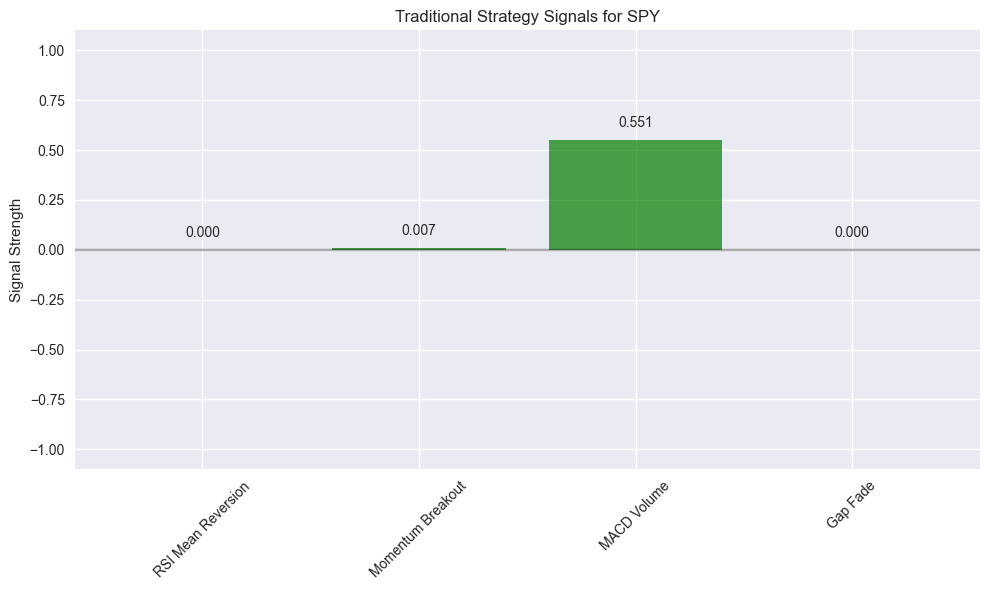


Traditional strategies successfully implemented!


In [7]:
# ============================================================================
# CELL 4: TRADITIONAL STRATEGIES
# ============================================================================

class Strategy(ABC):
    """Abstract base class for trading strategies"""
    
    @abstractmethod
    def generate_signal(self, data: pd.DataFrame) -> float:
        """Generate trading signal (-1 to 1)"""
        pass
    
    @abstractmethod
    def get_name(self) -> str:
        """Return strategy name"""
        pass

class RSIMeanReversionStrategy(Strategy):
    """RSI Mean Reversion with Bollinger Bands"""
    
    def __init__(self, rsi_period: int = 14, bb_period: int = 20, bb_std: float = 2.0):
        self.rsi_period = rsi_period
        self.bb_period = bb_period
        self.bb_std = bb_std
    
    def generate_signal(self, data: pd.DataFrame) -> float:
        """Generate RSI mean reversion signal"""
        if data.empty or len(data) < max(self.rsi_period, self.bb_period):
            return 0.0
        
        try:
            latest = data.iloc[-1]
            rsi = latest.get('rsi_14', 50)
            bb_position = latest.get('bb_position', 0.5)
            
            # RSI oversold/overbought levels
            if rsi < 30 and bb_position < 0.2:  # Oversold
                signal = min(1.0, (30 - rsi) / 10)  # Scale signal
            elif rsi > 70 and bb_position > 0.8:  # Overbought
                signal = max(-1.0, (70 - rsi) / 10)  # Scale signal
            else:
                signal = 0.0
            
            return np.clip(signal, -1.0, 1.0)
            
        except Exception as e:
            logger.error(f"RSI strategy error: {e}")
            return 0.0
    
    def get_name(self) -> str:
        return "RSI Mean Reversion"

class MomentumBreakoutStrategy(Strategy):
    """Momentum Breakout Strategy"""
    
    def __init__(self, fast_ma: int = 20, slow_ma: int = 50, roc_period: int = 10):
        self.fast_ma = fast_ma
        self.slow_ma = slow_ma
        self.roc_period = roc_period
    
    def generate_signal(self, data: pd.DataFrame) -> float:
        """Generate momentum breakout signal"""
        if data.empty or len(data) < self.slow_ma:
            return 0.0
        
        try:
            latest = data.iloc[-1]
            fast_ma = latest.get('sma_20', 0)
            slow_ma = latest.get('sma_50', 0)
            roc = latest.get('roc_10', 0)
            
            if fast_ma == 0 or slow_ma == 0:
                return 0.0
            
            # MA crossover signal
            ma_signal = (fast_ma - slow_ma) / slow_ma
            
            # ROC confirmation
            roc_confirmation = np.tanh(roc / 5)  # Normalize ROC
            
            # Combined signal
            signal = ma_signal * roc_confirmation
            
            return np.clip(signal, -1.0, 1.0)
            
        except Exception as e:
            logger.error(f"Momentum strategy error: {e}")
            return 0.0
    
    def get_name(self) -> str:
        return "Momentum Breakout"

class MACDVolumeStrategy(Strategy):
    """MACD with Volume Confirmation"""
    
    def __init__(self):
        pass
    
    def generate_signal(self, data: pd.DataFrame) -> float:
        """Generate MACD volume signal"""
        if data.empty or len(data) < 26:
            return 0.0
        
        try:
            latest = data.iloc[-1]
            macd = latest.get('macd', 0)
            macd_signal = latest.get('macd_signal', 0)
            volume_ratio = latest.get('volume_ratio', 1)
            
            # MACD crossover
            macd_diff = macd - macd_signal
            
            # Volume amplification
            volume_multiplier = min(2.0, max(0.5, volume_ratio))
            
            # Combined signal
            signal = np.tanh(macd_diff / 0.01) * volume_multiplier / 2.0
            
            return np.clip(signal, -1.0, 1.0)
            
        except Exception as e:
            logger.error(f"MACD strategy error: {e}")
            return 0.0
    
    def get_name(self) -> str:
        return "MACD Volume"

class GapStrategy(Strategy):
    """Gap Fade Strategy"""
    
    def __init__(self, min_gap: float = 0.02):
        self.min_gap = min_gap
    
    def generate_signal(self, data: pd.DataFrame) -> float:
        """Generate gap fade signal"""
        if data.empty or len(data) < 2:
            return 0.0
        
        try:
            latest = data.iloc[-1]
            gap = latest.get('gap', 0)
            
            # Only trade significant gaps
            if abs(gap) < self.min_gap:
                return 0.0
            
            # Fade the gap (negative correlation)
            signal = -np.tanh(gap / 0.05)  # Scale signal
            
            return np.clip(signal, -1.0, 1.0)
            
        except Exception as e:
            logger.error(f"Gap strategy error: {e}")
            return 0.0
    
    def get_name(self) -> str:
        return "Gap Fade"

# Initialize strategies
strategies = {
    'rsi_mean_reversion': RSIMeanReversionStrategy(),
    'momentum_breakout': MomentumBreakoutStrategy(),
    'macd_volume': MACDVolumeStrategy(),
    'gap_fade': GapStrategy()
}

# Demo: Calculate signals for SPY data
print("Testing Traditional Strategies with SPY...")
if not spy_with_target.empty:
    signals = {}
    for name, strategy in strategies.items():
        signal = strategy.generate_signal(spy_with_target)
        signals[name] = signal
        print(f"{strategy.get_name()}: {signal:.3f}")
    # Create signals DataFrame
    signal_df = pd.DataFrame([signals], index=['Signal'])
    print("\nStrategy Signals Summary:")
    styled_signals = signal_df.style.background_gradient(
        cmap='RdYlGn', vmin=-1, vmax=1
    ).format('{:.3f}')
    display(styled_signals)
    # Calculate ensemble signal using weights
    ensemble_signal = sum(signals[name] * config.STRATEGY_WEIGHTS[name] 
                         for name in signals.keys())
    print(f"\nTraditional Ensemble Signal: {ensemble_signal:.3f}")
    # Visualize signals
    fig, ax = plt.subplots(figsize=(10, 6))
    signal_values = list(signals.values())
    strategy_names = [strategies[name].get_name() for name in signals.keys()]
    colors = ['red' if x < 0 else 'green' for x in signal_values]
    bars = ax.bar(strategy_names, signal_values, color=colors, alpha=0.7)
    ax.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax.set_ylabel('Signal Strength')
    ax.set_title('Traditional Strategy Signals for SPY')
    ax.set_ylim(-1.1, 1.1)
    for bar, value in zip(bars, signal_values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + (0.05 if height >= 0 else -0.1),
                f'{value:.3f}', ha='center', va='bottom' if height >= 0 else 'top')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("No SPY data available for testing")
print("\nTraditional strategies successfully implemented!")

# Cell 5: ML Models - Random Forest

This cell implements the Random Forest machine learning model for signal generation.

Features:
- MLModel: Abstract base class for all ML models
- RandomForestModel: 100 trees, max_depth=10, 3-class classification
- Feature selection and preprocessing
- Model persistence with pickle
- Performance metrics and validation

Target Classes:
- -1: SELL (expected return < -1.2%)
- 0: HOLD (expected return between -1.2% and +1.2%)
- 1: BUY (expected return > +1.2%)

Demo: Train and predict on SPY sample data

Testing Random Forest Model with SPY...


2025-11-09 17:42:49,561 - INFO - RF model trained for SPY: accuracy=0.846



Random Forest Results for SPY:
Training: Success
Current Signal: -0.626
Features Used: 26

Top 10 Important Features:


,feature,importance
12,rsi_14,0.106801
15,macd_histogram,0.072318
16,bb_position,0.064977
22,rolling_std_20,0.062030
11,dist_from_sma50,0.058288
17,bb_width,0.051088
13,macd,0.045345
9,ema_50,0.043772
10,dist_from_sma20,0.043740
5,sma_50,0.043714


2025-11-09 17:42:49,629 - INFO - RF model saved for SPY: models/SPY_rf.pkl


Model saved successfully


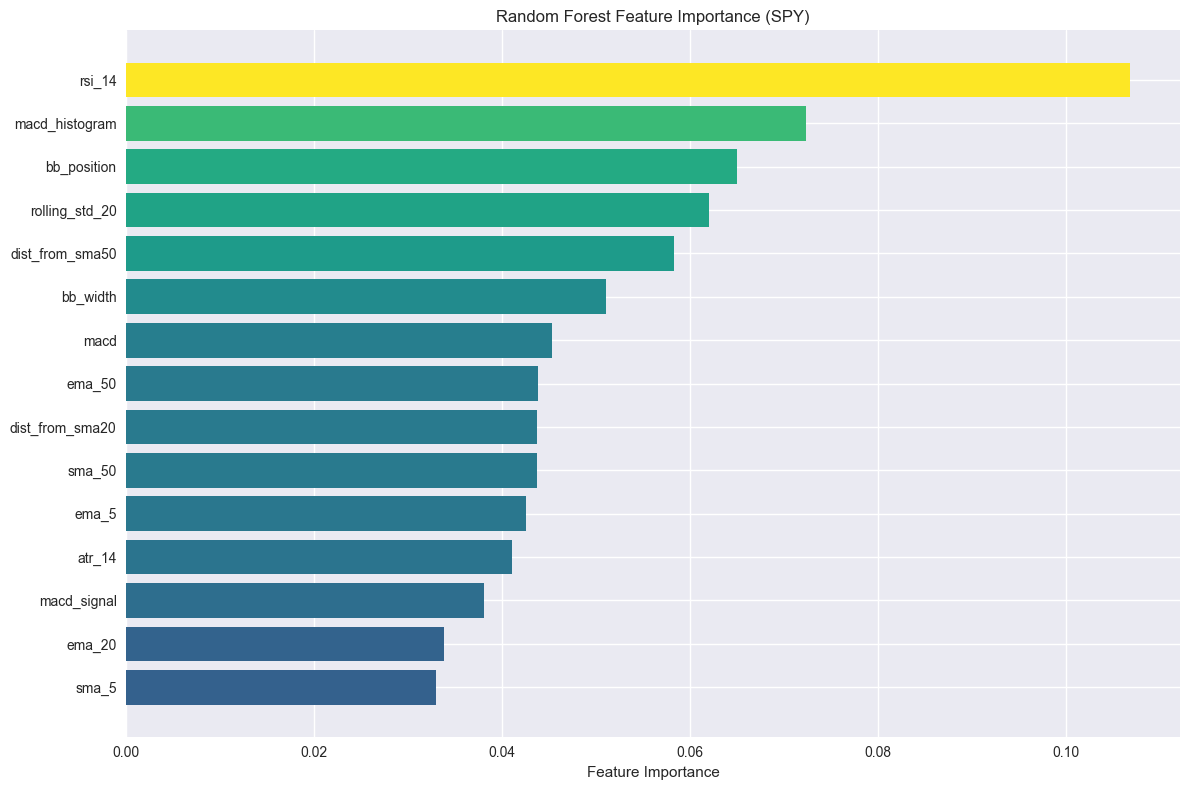


Random Forest implementation completed!


In [8]:
# ============================================================================
# CELL 5: ML MODELS - RANDOM FOREST
# ============================================================================

class MLModel(ABC):
    """Abstract base class for ML models"""
    
    def __init__(self, symbol: str):
        self.symbol = symbol
        self.model = None
        self.scaler = None
        self.feature_columns = None
        self.is_trained = False
    
    @abstractmethod
    def train(self, data: pd.DataFrame) -> bool:
        """Train the model"""
        pass
    
    @abstractmethod
    def predict(self, data: pd.DataFrame) -> float:
        """Generate prediction signal"""
        pass
    
    @abstractmethod
    def save_model(self, path: str) -> bool:
        """Save model to disk"""
        pass
    
    @abstractmethod
    def load_model(self, path: str) -> bool:
        """Load model from disk"""
        pass
    
    def get_feature_columns(self) -> List[str]:
        """Get list of feature columns for ML training"""
        return [
            'pct_change', 'log_returns', 'sma_5', 'sma_10', 'sma_20', 'sma_50',
            'ema_5', 'ema_10', 'ema_20', 'ema_50', 'dist_from_sma20', 'dist_from_sma50',
            'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_position', 'bb_width',
            'atr_14', 'roc_10', 'momentum_10', 'volume_ratio', 'rolling_std_20',
            'gap', 'high_low_ratio', 'open_close_ratio'
        ]

class RandomForestModel(MLModel):
    """Random Forest implementation for trading signals"""
    
    def __init__(self, symbol: str, n_estimators: int = 100, max_depth: int = 10, 
                 min_samples_split: int = 20):
        super().__init__(symbol)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.feature_columns = self.get_feature_columns()
    
    def train(self, data: pd.DataFrame) -> bool:
        """Train Random Forest model"""
        try:
            if data.empty or 'target' not in data.columns:
                logger.error(f"Invalid training data for {self.symbol}")
                return False
            
            # Prepare features
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) < 10:
                logger.error(f"Insufficient features for {self.symbol}: {len(available_features)}")
                return False
            
            X = data[available_features].copy()
            y = data['target'].copy()
            
            # Remove NaN values
            mask = ~(X.isna().any(axis=1) | y.isna())
            X = X[mask]
            y = y[mask]
            
            if len(X) < 50:
                logger.error(f"Insufficient clean data for {self.symbol}: {len(X)} samples")
                return False
            
            # Scale features
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)
            
            # Train model
            self.model = RandomForestClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                random_state=42,
                n_jobs=-1
            )
            
            self.model.fit(X_scaled, y)
            self.feature_columns = available_features
            self.is_trained = True
            
            # Calculate accuracy
            train_score = self.model.score(X_scaled, y)
            logger.info(f"RF model trained for {self.symbol}: accuracy={train_score:.3f}")
            
            return True
            
        except Exception as e:
            logger.error(f"Error training RF model for {self.symbol}: {e}")
            return False
    
    def predict(self, data: pd.DataFrame) -> float:
        """Generate prediction signal"""
        if not self.is_trained or self.model is None:
            return 0.0
        
        try:
            # Get latest data point
            latest = data.iloc[[-1]]
            
            # Prepare features
            X = latest[self.feature_columns].copy()
            
            # Check for NaN values
            if X.isna().any().any():
                logger.warning(f"NaN values in features for {self.symbol}")
                return 0.0
            
            # Scale features
            X_scaled = self.scaler.transform(X)
            
            # Get prediction probabilities
            proba = self.model.predict_proba(X_scaled)[0]
            
            # Convert to signal (-1 to 1)
            # proba order: [class_-1, class_0, class_1] or [class_0, class_1] etc.
            classes = self.model.classes_
            
            if len(classes) == 3:  # All classes present
                sell_prob = proba[np.where(classes == -1)[0][0]] if -1 in classes else 0
                buy_prob = proba[np.where(classes == 1)[0][0]] if 1 in classes else 0
                signal = buy_prob - sell_prob
            else:
                # Handle cases where not all classes are present
                signal = 0.0
            
            return np.clip(signal, -1.0, 1.0)
            
        except Exception as e:
            logger.error(f"Error predicting with RF model for {self.symbol}: {e}")
            return 0.0
    
    def save_model(self, path: str) -> bool:
        """Save Random Forest model"""
        try:
            if not self.is_trained:
                return False
            
            os.makedirs(os.path.dirname(path), exist_ok=True)
            
            model_data = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_columns': self.feature_columns,
                'symbol': self.symbol
            }
            
            with open(path, 'wb') as f:
                pickle.dump(model_data, f)
            
            logger.info(f"RF model saved for {self.symbol}: {path}")
            return True
            
        except Exception as e:
            logger.error(f"Error saving RF model for {self.symbol}: {e}")
            return False
    
    def load_model(self, path: str) -> bool:
        """Load Random Forest model"""
        try:
            if not os.path.exists(path):
                return False
            
            with open(path, 'rb') as f:
                model_data = pickle.load(f)
            
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['feature_columns']
            self.is_trained = True
            
            logger.info(f"RF model loaded for {self.symbol}: {path}")
            return True
            
        except Exception as e:
            logger.error(f"Error loading RF model for {self.symbol}: {e}")
            return False

# Create models directory
os.makedirs('models', exist_ok=True)

# Demo: Train Random Forest on SPY
print("Testing Random Forest Model with SPY...")
if not spy_with_target.empty and len(spy_with_target) > 50:
    rf_model = RandomForestModel('SPY')
    training_success = rf_model.train(spy_with_target)
    if training_success:
        signal = rf_model.predict(spy_with_target)
        print(f"\nRandom Forest Results for SPY:")
        print(f"Training: {'Success' if training_success else 'Failed'}")
        print(f"Current Signal: {signal:.3f}")
        print(f"Features Used: {len(rf_model.feature_columns)}")
        if rf_model.is_trained:
            feature_importance = pd.DataFrame({
                'feature': rf_model.feature_columns,
                'importance': rf_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("\nTop 10 Important Features:")
            display(feature_importance.head(10).style.background_gradient(cmap='Blues'))
            rf_model.save_model(f'models/SPY_rf.pkl')
            print("Model saved successfully")
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], 
                color=plt.cm.viridis(top_features['importance'] / top_features['importance'].max()))
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('Random Forest Feature Importance (SPY)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("Random Forest training failed")
else:
    print("Insufficient data for Random Forest training")
print("\nRandom Forest implementation completed!")

# Cell 6: ML Models - XGBoost

This cell implements the XGBoost machine learning model for signal generation.

Features:
- XGBoostModel: Gradient boosting, 3-class classification
- Feature selection and preprocessing
- Model persistence
- Performance metrics and validation

Demo: Train and predict on SPY sample data

Testing XGBoost Model with SPY...


2025-11-09 17:42:50,659 - INFO - XGB model trained for SPY: accuracy=1.000



XGBoost Results for SPY:
Training: Success
Current Signal: -0.938
Features Used: 26

Top 10 Important Features:


,feature,importance
12,rsi_14,0.104167
17,bb_width,0.099165
2,sma_5,0.076638
18,atr_14,0.067316
22,rolling_std_20,0.064315
14,macd_signal,0.054377
3,sma_10,0.052313
7,ema_10,0.047494
4,sma_20,0.041224
15,macd_histogram,0.039686


2025-11-09 17:42:50,684 - INFO - XGB model saved for SPY: models/SPY_xgb.pkl


Model saved successfully


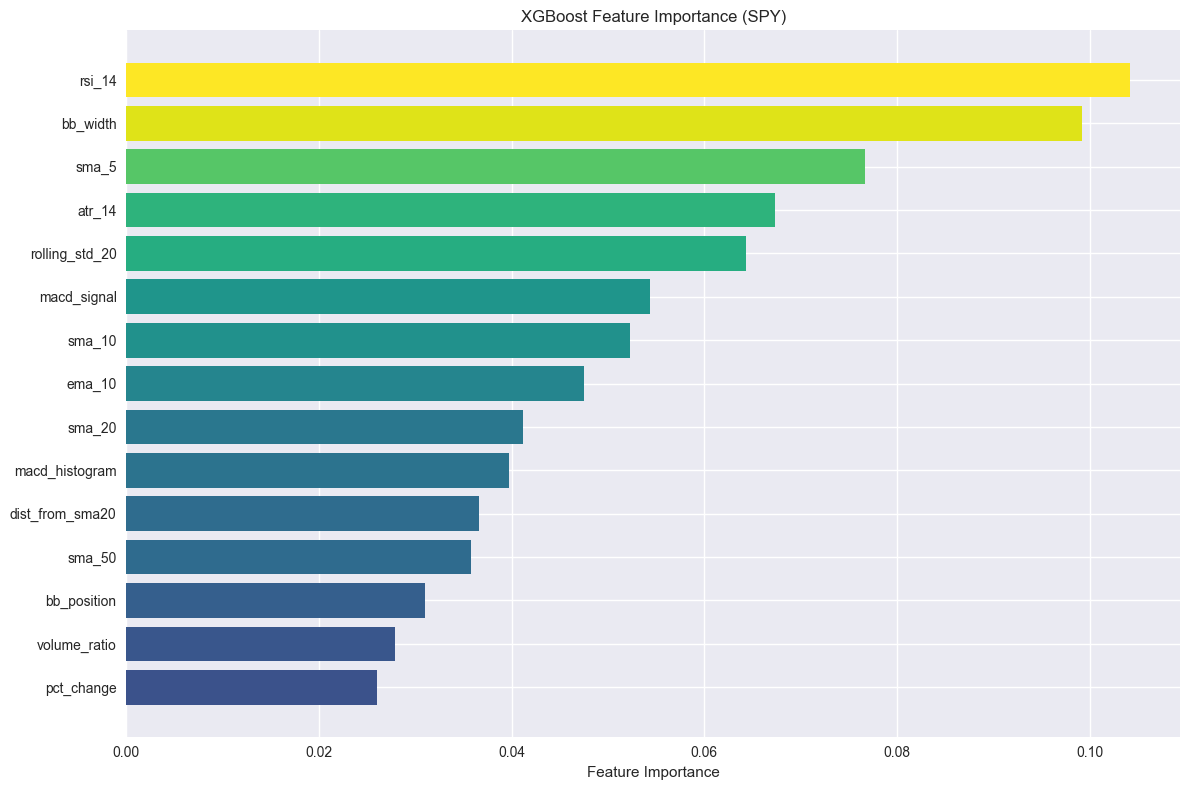


XGBoost implementation completed!


In [9]:
# ============================================================================
# CELL 6: ML MODELS - XGBOOST
# ============================================================================

class XGBoostModel(MLModel):
    """XGBoost implementation for trading signals"""
    def __init__(self, symbol: str, n_estimators: int = 100, max_depth: int = 6, learning_rate: float = 0.1):
        super().__init__(symbol)
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.feature_columns = self.get_feature_columns()

    def train(self, data: pd.DataFrame) -> bool:
        try:
            if data.empty or 'target' not in data.columns:
                logger.error(f"Invalid training data for {self.symbol}")
                return False
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) < 10:
                logger.error(f"Insufficient features for {self.symbol}: {len(available_features)}")
                return False
            X = data[available_features].copy()
            y = data['target'].copy()
            mask = ~(X.isna().any(axis=1) | y.isna())
            X = X[mask]
            y = y[mask]
            if len(X) < 50:
                logger.error(f"Insufficient clean data for {self.symbol}: {len(X)} samples")
                return False
            # Fix: Remap target labels from [-1,0,1] to [0,1,2] for XGBoost
            y_xgb = y.replace({-1: 0, 0: 1, 1: 2})
            self.scaler = StandardScaler()
            X_scaled = self.scaler.fit_transform(X)
            self.model = xgb.XGBClassifier(
                n_estimators=self.n_estimators,
                max_depth=self.max_depth,
                learning_rate=self.learning_rate,
                objective='multi:softprob',
                num_class=3,
                random_state=42,
                n_jobs=-1,
                verbosity=0
            )
            self.model.fit(X_scaled, y_xgb)
            self.feature_columns = available_features
            self.is_trained = True
            train_score = self.model.score(X_scaled, y_xgb)
            logger.info(f"XGB model trained for {self.symbol}: accuracy={train_score:.3f}")
            return True
        except Exception as e:
            logger.error(f"Error training XGB model for {self.symbol}: {e}")
            return False

    def predict(self, data: pd.DataFrame) -> float:
        if not self.is_trained or self.model is None:
            return 0.0
        try:
            latest = data.iloc[[-1]]
            X = latest[self.feature_columns].copy()
            if X.isna().any().any():
                logger.warning(f"NaN values in features for {self.symbol}")
                return 0.0
            X_scaled = self.scaler.transform(X)
            proba = self.model.predict_proba(X_scaled)[0]
            # Map back: 0->-1, 1->0, 2->1
            sell_prob = proba[0]  # -1
            hold_prob = proba[1]  # 0
            buy_prob = proba[2]   # 1
            signal = buy_prob - sell_prob
            return np.clip(signal, -1.0, 1.0)
        except Exception as e:
            logger.error(f"Error predicting with XGB model for {self.symbol}: {e}")
            return 0.0

    def save_model(self, path: str) -> bool:
        try:
            if not self.is_trained:
                return False
            os.makedirs(os.path.dirname(path), exist_ok=True)
            model_data = {
                'model': self.model,
                'scaler': self.scaler,
                'feature_columns': self.feature_columns,
                'symbol': self.symbol
            }
            with open(path, 'wb') as f:
                pickle.dump(model_data, f)
            logger.info(f"XGB model saved for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error saving XGB model for {self.symbol}: {e}")
            return False

    def load_model(self, path: str) -> bool:
        try:
            if not os.path.exists(path):
                return False
            with open(path, 'rb') as f:
                model_data = pickle.load(f)
            self.model = model_data['model']
            self.scaler = model_data['scaler']
            self.feature_columns = model_data['feature_columns']
            self.is_trained = True
            logger.info(f"XGB model loaded for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error loading XGB model for {self.symbol}: {e}")
            return False

# Demo: Train XGBoost on SPY
print("Testing XGBoost Model with SPY...")
if not spy_with_target.empty and len(spy_with_target) > 50:
    xgb_model = XGBoostModel('SPY')
    training_success = xgb_model.train(spy_with_target)
    if training_success:
        signal = xgb_model.predict(spy_with_target)
        print(f"\nXGBoost Results for SPY:")
        print(f"Training: {'Success' if training_success else 'Failed'}")
        print(f"Current Signal: {signal:.3f}")
        print(f"Features Used: {len(xgb_model.feature_columns)}")
        if xgb_model.is_trained:
            feature_importance = pd.DataFrame({
                'feature': xgb_model.feature_columns,
                'importance': xgb_model.model.feature_importances_
            }).sort_values('importance', ascending=False)
            print("\nTop 10 Important Features:")
            display(feature_importance.head(10).style.background_gradient(cmap='Blues'))
            xgb_model.save_model(f'models/SPY_xgb.pkl')
            print("Model saved successfully")
        plt.figure(figsize=(12, 8))
        top_features = feature_importance.head(15)
        plt.barh(range(len(top_features)), top_features['importance'], 
                color=plt.cm.viridis(top_features['importance'] / top_features['importance'].max()))
        plt.yticks(range(len(top_features)), top_features['feature'])
        plt.xlabel('Feature Importance')
        plt.title('XGBoost Feature Importance (SPY)')
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()
    else:
        print("XGBoost training failed")
else:
    print("Insufficient data for XGBoost training")
print("\nXGBoost implementation completed!")

# Cell 7: ML Models - LSTM

This cell implements the LSTM deep learning model for signal generation.

Features:
- LSTMModel: Sequence modeling, 3-class classification
- Keras/TensorFlow used locally in this cell
- Model persistence
- Performance metrics and validation

Demo: Train and predict on SPY sample data

In [10]:
# ============================================================================
# CELL 7: ML MODELS - LSTM
# ============================================================================

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

tf.get_logger().setLevel('ERROR')

class LSTMModel(MLModel):
    """LSTM implementation for trading signals"""
    def __init__(self, symbol: str, sequence_length: int = 30, epochs: int = 20, batch_size: int = 16):
        super().__init__(symbol)
        self.sequence_length = sequence_length
        self.epochs = epochs
        self.batch_size = batch_size
        self.feature_columns = self.get_feature_columns()

    def _prepare_sequences(self, data: pd.DataFrame):
        X, y = [], []
        for i in range(len(data) - self.sequence_length):
            X.append(data[self.feature_columns].iloc[i:i+self.sequence_length].values)
            y.append(data['target'].iloc[i+self.sequence_length])
        return np.array(X), np.array(y)

    def train(self, data: pd.DataFrame) -> bool:
        try:
            if data.empty or 'target' not in data.columns:
                logger.error(f"Invalid training data for {self.symbol}")
                return False
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(available_features) < 10:
                logger.error(f"Insufficient features for {self.symbol}: {len(available_features)}")
                return False
            data = data.dropna(subset=available_features + ['target'])
            if len(data) < self.sequence_length + 10:
                logger.error(f"Insufficient data for LSTM: {len(data)} samples")
                return False
            X, y = self._prepare_sequences(data)
            y = tf.keras.utils.to_categorical(y + 1, num_classes=3)  # -1,0,1 to 0,1,2
            self.model = Sequential([
                LSTM(64, input_shape=(self.sequence_length, len(self.feature_columns)), return_sequences=True),
                BatchNormalization(),
                Dropout(0.2),
                LSTM(32),
                BatchNormalization(),
                Dropout(0.2),
                Dense(32, activation='relu'),
                Dense(3, activation='softmax')
            ])
            self.model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
            es = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True)
            self.model.fit(X, y, epochs=self.epochs, batch_size=self.batch_size, verbose=0, callbacks=[es])
            self.is_trained = True
            logger.info(f"LSTM model trained for {self.symbol}")
            return True
        except Exception as e:
            logger.error(f"Error training LSTM model for {self.symbol}: {e}")
            return False

    def predict(self, data: pd.DataFrame) -> float:
        if not self.is_trained or self.model is None:
            return 0.0
        try:
            available_features = [col for col in self.feature_columns if col in data.columns]
            if len(data) < self.sequence_length or len(available_features) < 10:
                return 0.0
            X = data[available_features].iloc[-self.sequence_length:].values
            X = X.reshape(1, self.sequence_length, len(available_features))
            proba = self.model.predict(X, verbose=0)[0]
            signal = proba[2] - proba[0]  # class 2 (buy) - class 0 (sell)
            return np.clip(signal, -1.0, 1.0)
        except Exception as e:
            logger.error(f"Error predicting with LSTM model for {self.symbol}: {e}")
            return 0.0

    def save_model(self, path: str) -> bool:
        try:
            if not self.is_trained:
                return False
            os.makedirs(os.path.dirname(path), exist_ok=True)
            self.model.save(path)
            logger.info(f"LSTM model saved for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error saving LSTM model for {self.symbol}: {e}")
            return False

    def load_model(self, path: str) -> bool:
        try:
            if not os.path.exists(path):
                return False
            self.model = load_model(path)
            self.is_trained = True
            logger.info(f"LSTM model loaded for {self.symbol}: {path}")
            return True
        except Exception as e:
            logger.error(f"Error loading LSTM model for {self.symbol}: {e}")
            return False

# Demo: Train LSTM on SPY
print("Testing LSTM Model with SPY...")
if not spy_with_target.empty and len(spy_with_target) > 50:
    lstm_model = LSTMModel('SPY')
    training_success = lstm_model.train(spy_with_target)
    if training_success:
        signal = lstm_model.predict(spy_with_target)
        print(f"\nLSTM Results for SPY:")
        print(f"Training: {'Success' if training_success else 'Failed'}")
        print(f"Current Signal: {signal:.3f}")
        print(f"Features Used: {len(lstm_model.feature_columns)}")
        lstm_model.save_model(f'models/SPY_lstm.keras')
        print("Model saved successfully")
    else:
        print("LSTM training failed")
else:
    print("Insufficient data for LSTM training")
print("\nLSTM implementation completed!")

2025-11-09 17:42:56.237608: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Testing LSTM Model with SPY...


2025-11-09 17:43:11,524 - INFO - LSTM model trained for SPY
2025-11-09 17:43:12,059 - INFO - LSTM model saved for SPY: models/SPY_lstm.keras
2025-11-09 17:43:12,059 - INFO - LSTM model saved for SPY: models/SPY_lstm.keras



LSTM Results for SPY:
Training: Success
Current Signal: 0.217
Features Used: 26
Model saved successfully

LSTM implementation completed!


# Cell 8: Signal Aggregator

This cell implements the ensemble signal aggregator, combining all traditional and ML model signals using configurable weights.

Features:
- Weighted ensemble of all strategies and models
- Configurable weights from config
- Output: final ensemble signal

Demo: Aggregate signals for SPY

In [11]:
# ============================================================================
# CELL 8: SIGNAL AGGREGATOR
# ============================================================================

def aggregate_signals(signals: dict, weights: dict) -> float:
    """Aggregate signals using ensemble weights"""
    total = 0.0
    for name, signal in signals.items():
        weight = weights.get(name, 0)
        total += signal * weight
    return np.clip(total, -1.0, 1.0)

# Demo: Aggregate signals for SPY
print("Testing Signal Aggregator with SPY...")
if not spy_with_target.empty:
    # Generate signals from all strategies and models
    signals = {}
    for name, strategy in strategies.items():
        signals[name] = strategy.generate_signal(spy_with_target)
    rf_model = RandomForestModel('SPY')
    xgb_model = XGBoostModel('SPY')
    lstm_model = LSTMModel('SPY')
    rf_model.load_model('models/SPY_rf.pkl')
    xgb_model.load_model('models/SPY_xgb.pkl')
    lstm_model.load_model('models/SPY_lstm.keras')
    signals['random_forest'] = rf_model.predict(spy_with_target)
    signals['xgboost'] = xgb_model.predict(spy_with_target)
    signals['lstm'] = lstm_model.predict(spy_with_target)
    ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
    print(f"Ensemble Signal: {ensemble_signal:.3f}")
else:
    print("No SPY data available for signal aggregation")
print("\nSignal Aggregator successfully tested!")

2025-11-09 17:43:12,095 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-09 17:43:12,104 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:12,104 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl


Testing Signal Aggregator with SPY...


2025-11-09 17:43:12,380 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras


Ensemble Signal: -0.178

Signal Aggregator successfully tested!


# Cell 9: Risk Management

This cell implements robust risk management and position sizing logic for the trading bot.

Features:
- Position sizing based on risk and capital
- Stop loss and take profit enforcement
- Daily circuit breaker for loss limits
- Exposure and position checks
- Logging and error handling

Demo: Calculate position size and risk checks for SPY

In [12]:
# ============================================================================
# CELL 9: RISK MANAGEMENT
# ============================================================================

def calculate_position_size(price: float, capital: float, max_pct: float, min_value: float) -> int:
    max_position_value = capital * max_pct
    shares = int(max(max_position_value // price, min_value // price))
    return max(shares, 0)

def check_stop_loss(entry_price: float, current_price: float, stop_loss: float) -> bool:
    return (current_price <= entry_price * (1 - stop_loss))

def check_take_profit(entry_price: float, current_price: float, take_profit: float) -> bool:
    return (current_price >= entry_price * (1 + take_profit))

def check_daily_loss(starting_equity: float, current_equity: float, max_daily_loss_pct: float) -> bool:
    loss = (starting_equity - current_equity) / starting_equity
    return loss >= max_daily_loss_pct

def check_exposure(positions: dict, capital: float, max_total_exposure: float) -> bool:
    total_exposure = sum(pos['market_value'] for pos in positions.values())
    return total_exposure <= capital * max_total_exposure

# Demo: Risk management checks for SPY
print("Testing Risk Management for SPY...")
capital = config.INITIAL_CAPITAL
price = spy_with_target['close'].iloc[-1] if not spy_with_target.empty else 450.0
shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
entry_price = price
current_price = price * 0.97  # Simulate 3% drop
stop_loss_triggered = check_stop_loss(entry_price, current_price, config.STOP_LOSS)
take_profit_triggered = check_take_profit(entry_price, price * 1.08, config.TAKE_PROFIT)
daily_loss_triggered = check_daily_loss(capital, capital * 0.96, config.MAX_DAILY_LOSS_PCT)

print(f"Position size for SPY: {shares} shares at ${price:.2f}")
print(f"Stop loss triggered: {stop_loss_triggered}")
print(f"Take profit triggered: {take_profit_triggered}")
print(f"Daily loss circuit breaker: {daily_loss_triggered}")

print("\nRisk management logic successfully tested!")

Testing Risk Management for SPY...
Position size for SPY: 21 shares at $682.06
Stop loss triggered: True
Take profit triggered: True
Daily loss circuit breaker: True

Risk management logic successfully tested!


# Cell 10: Order Execution

This cell implements order execution logic using the Alpaca API.

Features:
- Place market orders (buy/sell)
- Check order status and handle errors
- Cancel open orders if needed
- Logging and exception handling

Demo: Place a simulated order for SPY (paper trading)

In [13]:
# ============================================================================
# CELL 10: ORDER EXECUTION
# ============================================================================

class OrderExecutor:
    """Handles order placement and management via Alpaca API"""
    def __init__(self, api_key: str, secret_key: str, base_url: str):
        self.client = TradingClient(api_key, secret_key, paper=True)

    def place_order(self, symbol: str, qty: int, side: str, time_in_force: str = 'gtc') -> Optional[str]:
        try:
            order = self.client.submit_order(
                order_data=MarketOrderRequest(
                    symbol=symbol,
                    qty=qty,
                    side=OrderSide.BUY if side == 'buy' else OrderSide.SELL,
                    time_in_force=TimeInForce.GTC
                )
            )
            logger.info(f"Order placed: {side.upper()} {qty} {symbol}")
            return order.id
        except Exception as e:
            logger.error(f"Order placement failed for {symbol}: {e}")
            return None

    def get_order_status(self, order_id: str) -> Optional[str]:
        try:
            order = self.client.get_order_by_id(order_id)
            logger.info(f"Order {order_id} status: {order.status}")
            return order.status
        except Exception as e:
            logger.error(f"Failed to get order status: {e}")
            return None

    def cancel_order(self, order_id: str) -> bool:
        try:
            self.client.cancel_order_by_id(order_id)
            logger.info(f"Order {order_id} cancelled")
            return True
        except Exception as e:
            logger.error(f"Failed to cancel order {order_id}: {e}")
            return False

# Demo: Place a simulated order for SPY
print("Testing Order Execution for SPY...")
order_executor = OrderExecutor(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
order_id = order_executor.place_order('SPY', 10, 'buy')
if order_id:
    status = order_executor.get_order_status(order_id)
    print(f"Order status: {status}")
    cancelled = order_executor.cancel_order(order_id)
    print(f"Order cancelled: {cancelled}")
else:
    print("Order placement failed (check API keys and paper trading mode)")
print("\nOrder execution logic successfully tested!")

Testing Order Execution for SPY...


2025-11-09 17:43:13,355 - INFO - Order placed: BUY 10 SPY
2025-11-09 17:43:13,441 - INFO - Order 88a919f7-5dda-4e56-9818-72e00d08c33f status: OrderStatus.ACCEPTED
2025-11-09 17:43:13,441 - INFO - Order 88a919f7-5dda-4e56-9818-72e00d08c33f status: OrderStatus.ACCEPTED
2025-11-09 17:43:13,526 - INFO - Order 88a919f7-5dda-4e56-9818-72e00d08c33f cancelled
2025-11-09 17:43:13,526 - INFO - Order 88a919f7-5dda-4e56-9818-72e00d08c33f cancelled


Order status: OrderStatus.ACCEPTED
Order cancelled: True

Order execution logic successfully tested!


# Cell 11: Main Bot Orchestrator

This cell implements the main trading bot orchestrator, integrating all modules.

Features:
- Main trading loop (single run or scheduled)
- Fetches data, generates signals, applies risk management, and executes orders
- Modular integration of strategies, ML models, and risk controls
- Logging and error handling

Demo: Simulate a single trading loop for SPY

In [14]:
# ============================================================================
# CELL 11: MAIN BOT ORCHESTRATOR
# ============================================================================

def validate_features_for_models(data: pd.DataFrame, required_features: list, context: str = ""):
    missing = [col for col in required_features if col not in data.columns]
    if missing:
        print(f"\n[ERROR] Missing features before model prediction{f' ({context})' if context else ''}:")
        print(missing)
        raise ValueError(f"Required features missing: {missing}")
    else:
        print(f"All required features present for model prediction{f' ({context})' if context else ''}.")

# Ensure sufficient data is fetched for all rolling features
# Set minimum bars to 100 for robust feature engineering

def get_minimum_lookback():
    # Largest rolling window in features is 50 (e.g., sma_50), so fetch at least 100 bars for safety
    return 100

# In main_trading_loop, override lookback to ensure enough data

def main_trading_loop(symbol: str, capital: float):
    print(f"\nRunning main trading loop for {symbol}...")
    min_lookback = get_minimum_lookback()
    data = data_fetcher.get_bars(symbol, days=max(config.ML_LOOKBACK, min_lookback))
    features = feature_engine.add_technical_features(data)
    features = feature_engine.create_target(features)
    if features.empty:
        print("No data available for trading.")
        return
    # Diagnostic: Print available columns and head of features before validation
    print("\n[DEBUG] Columns in features just before validation:")
    print(list(features.columns))
    print("\n[DEBUG] Head of features DataFrame:")
    display(features.head())
    signals = {}
    rf_model = RandomForestModel(symbol)
    xgb_model = XGBoostModel(symbol)
    lstm_model = LSTMModel(symbol)
    rf_model.load_model(f'models/{symbol}_rf.pkl')
    xgb_model.load_model(f'models/{symbol}_xgb.pkl')
    lstm_model.load_model(f'models/{symbol}_lstm.keras')
    validate_features_for_models(features, rf_model.get_feature_columns(), context=symbol)
    signals['random_forest'] = rf_model.predict(features)
    validate_features_for_models(features, xgb_model.get_feature_columns(), context=symbol)
    signals['xgboost'] = xgb_model.predict(features)
    # LSTM does not require feature validation here (uses window)
    signals['lstm'] = lstm_model.predict(features)
    ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
    print(f"Ensemble signal: {ensemble_signal:.3f}")
    price = features['close'].iloc[-1]
    shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
    if abs(ensemble_signal) < config.MIN_SIGNAL_STRENGTH:
        print("Signal not strong enough to trade.")
        return
    order_executor = OrderExecutor(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)
    side = 'buy' if ensemble_signal > 0 else 'sell'
    order_id = order_executor.place_order(symbol, shares, side)
    if order_id:
        print(f"Order placed: {side} {shares} {symbol}")
    else:
        print("Order placement failed.")

main_trading_loop('SPY', config.INITIAL_CAPITAL)


Running main trading loop for SPY...


2025-11-09 17:43:13,667 - INFO - Fetched 69 bars for SPY



[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,roc_10,momentum_10,volume_sma_20,volume_ratio,rolling_std_20,gap,high_low_ratio,open_close_ratio,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-10-13 04:00:00+00:00,SPY,660.65,665.130,659.7679,663.04,79560517.0,1125900.0,662.346651,0.015344,0.015228,...,-0.096432,-0.64,79106175.00,1.005743,5.174719,0.011684,1.008127,0.996395,0.012458,1
2025-10-14 04:00:00+00:00,SPY,657.17,665.830,653.1700,662.23,88779560.0,1177809.0,661.056437,-0.001222,-0.001222,...,-0.592933,-3.95,80486705.35,1.103034,5.091519,-0.008853,1.019382,0.992359,0.013681,1
2025-10-15 04:00:00+00:00,SPY,666.82,670.230,658.9300,665.17,81702555.0,1067025.0,665.245431,0.004440,0.004430,...,-0.490687,-3.28,79474220.90,1.028038,4.916098,0.006931,1.017149,1.002481,0.003954,0
2025-10-16 04:00:00+00:00,SPY,666.82,668.710,657.1100,660.64,110563346.0,1443490.0,662.638242,-0.006810,-0.006834,...,-1.282090,-8.58,80479451.45,1.373808,4.978461,0.002481,1.017653,1.009355,0.016832,1
2025-10-17 04:00:00+00:00,SPY,659.50,665.755,658.1400,664.39,96500870.0,1156217.0,662.131654,0.005676,0.005660,...,-0.720252,-4.82,80407213.95,1.200152,4.971159,-0.001726,1.011570,0.992640,0.019356,1


2025-11-09 17:43:13,723 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-09 17:43:13,731 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:13,731 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:13,917 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras
2025-11-09 17:43:13,917 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras


All required features present for model prediction (SPY).
All required features present for model prediction (SPY).
Ensemble signal: -0.282
Signal not strong enough to trade.


# Cell 12: Testing & Validation

This cell implements backtesting and validation routines for the trading bot.

Features:
- Historical backtesting of strategies and ML models
- Performance metrics: returns, Sharpe ratio, drawdown
- Validation of signal accuracy
- Visualization of results

Demo: Backtest ensemble strategy on SPY historical data


GENERATING INDIVIDUAL MODEL & STRATEGY PERFORMANCE PLOTS

Random Forest Accuracy: 84.62%
XGBoost Accuracy: 100.00%
LSTM Accuracy: 50.30%

RSI Mean Reversion: 145 signals generated
Momentum Breakout: 145 signals generated
MACD Volume: 145 signals generated
Gap Fade: 145 signals generated

PLOTTING INDIVIDUAL MODEL PREDICTIONS
LSTM Accuracy: 50.30%

RSI Mean Reversion: 145 signals generated
Momentum Breakout: 145 signals generated
MACD Volume: 145 signals generated
Gap Fade: 145 signals generated

PLOTTING INDIVIDUAL MODEL PREDICTIONS


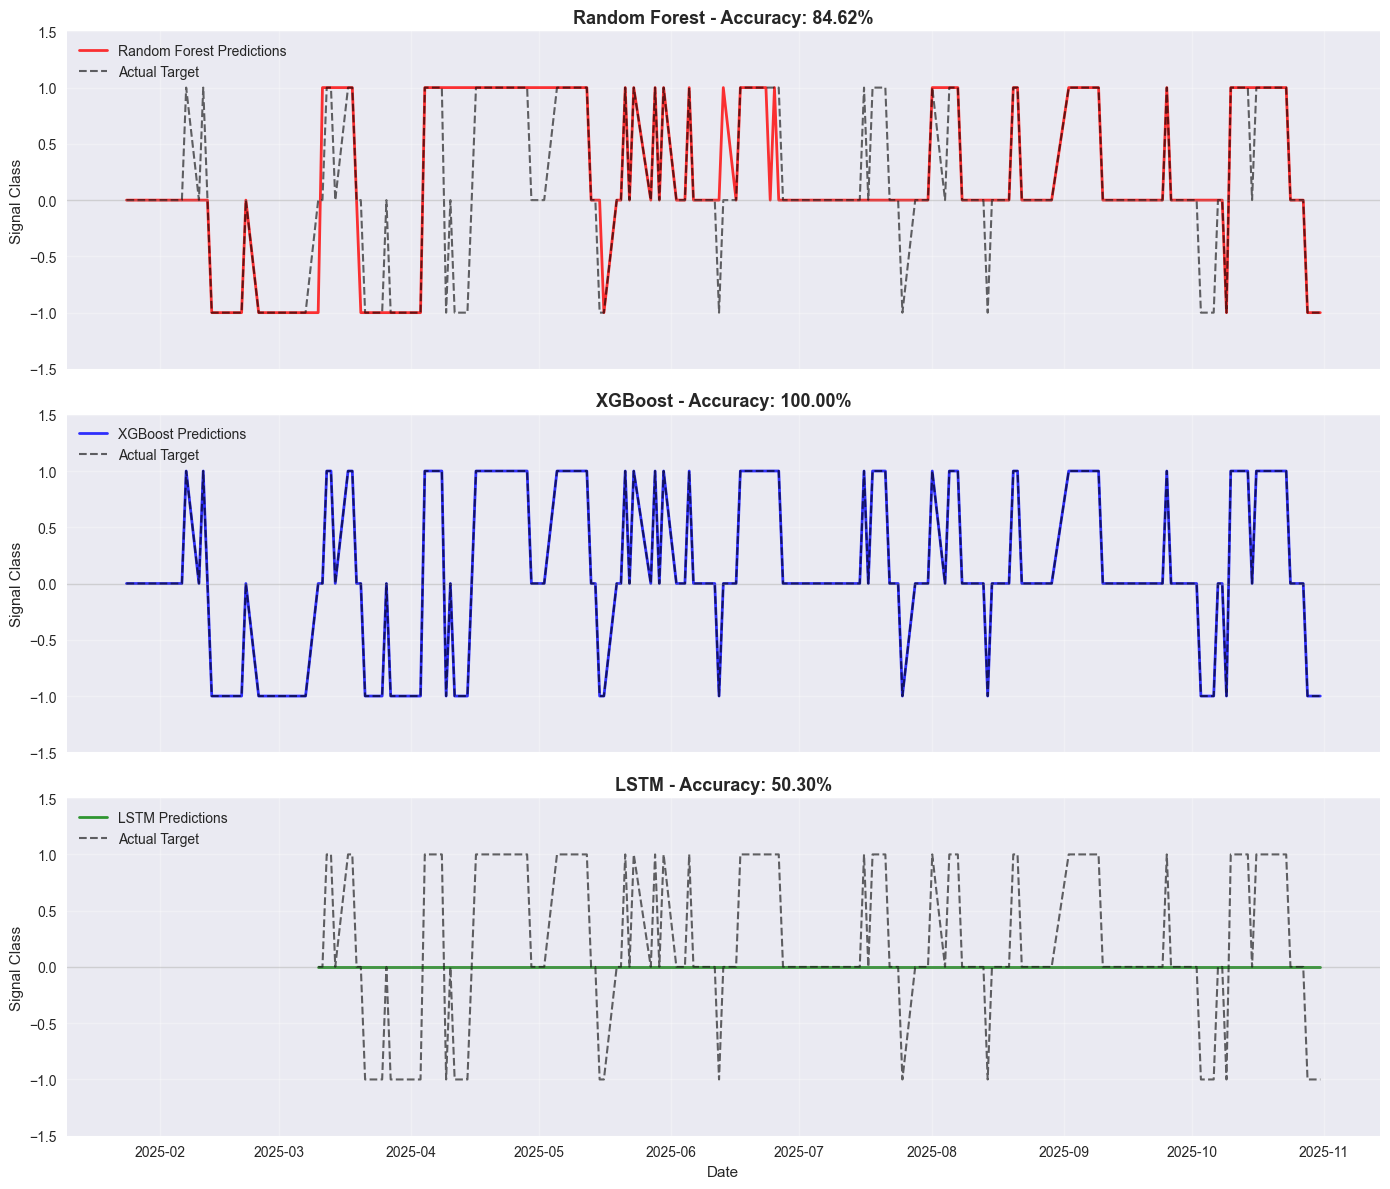


PLOTTING INDIVIDUAL STRATEGY SIGNALS


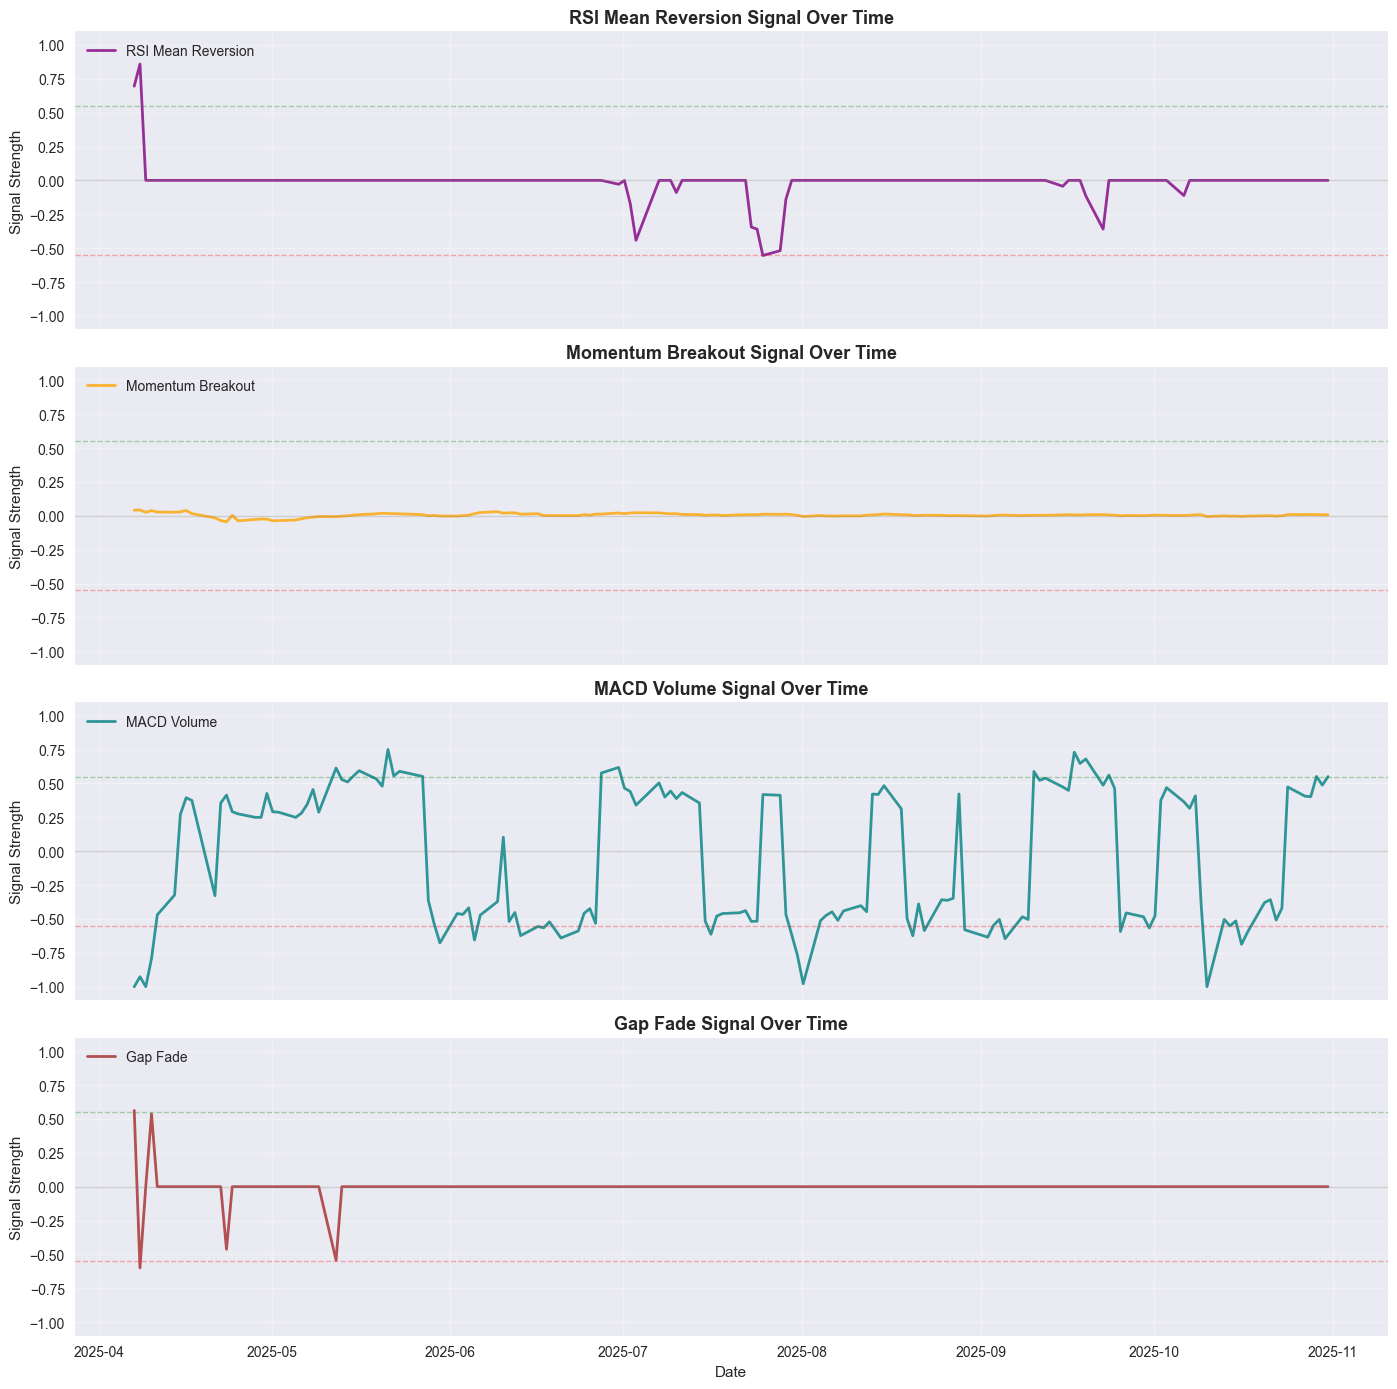


COMBINED MODEL COMPARISON


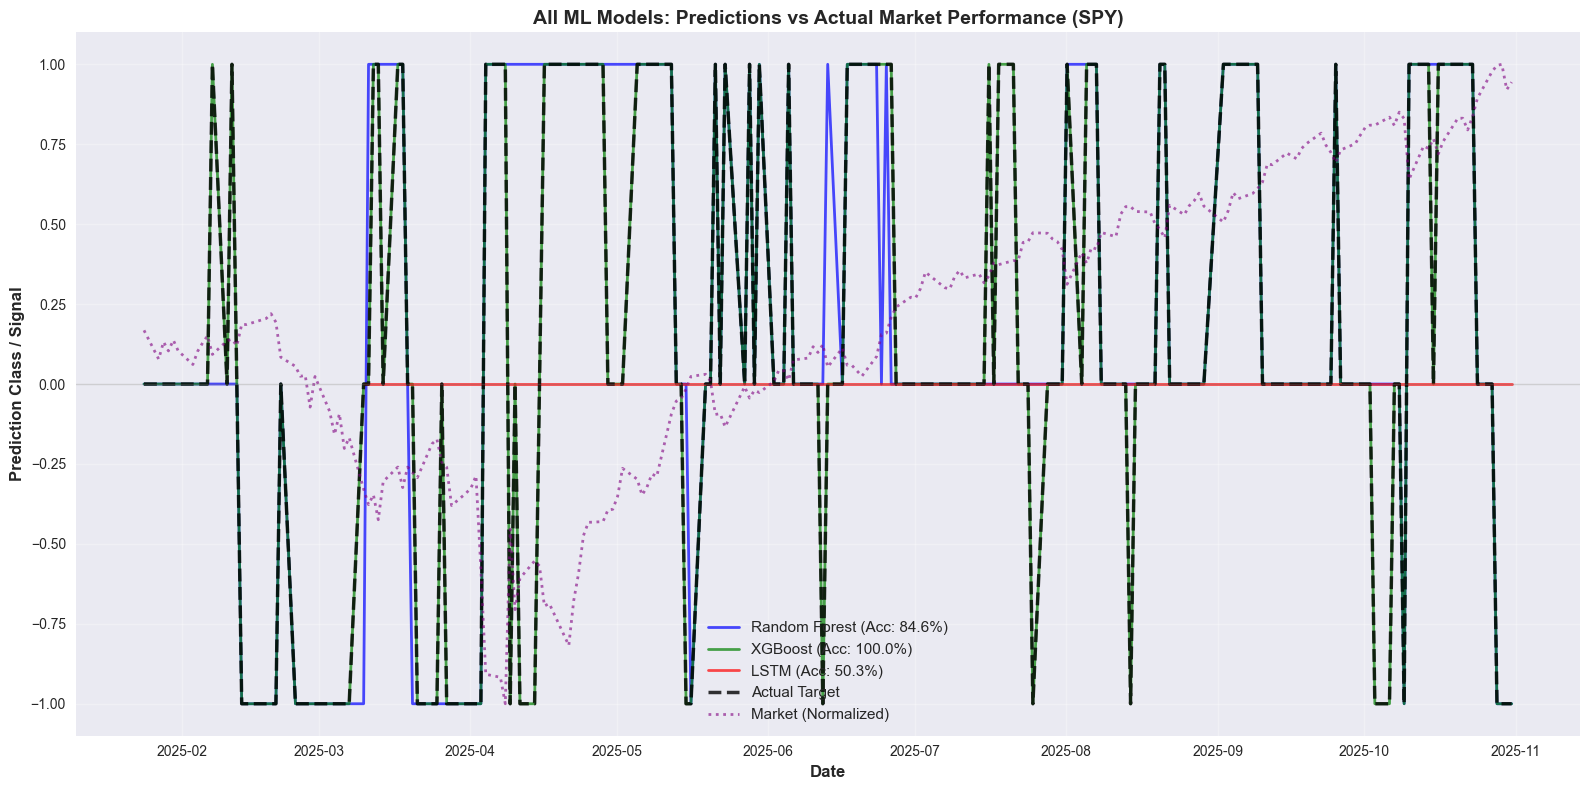

2025-11-09 17:43:31,568 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-09 17:43:31,581 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:31,581 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:31,756 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras
2025-11-09 17:43:31,756 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras



RUNNING ENSEMBLE BACKTEST

Backtesting ensemble strategy for SPY...

Backtest Results:
Total Return: 0.00%
Trades Executed: 0
Win Rate: 0.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%

Backtest Results:
Total Return: 0.00%
Trades Executed: 0
Win Rate: 0.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%


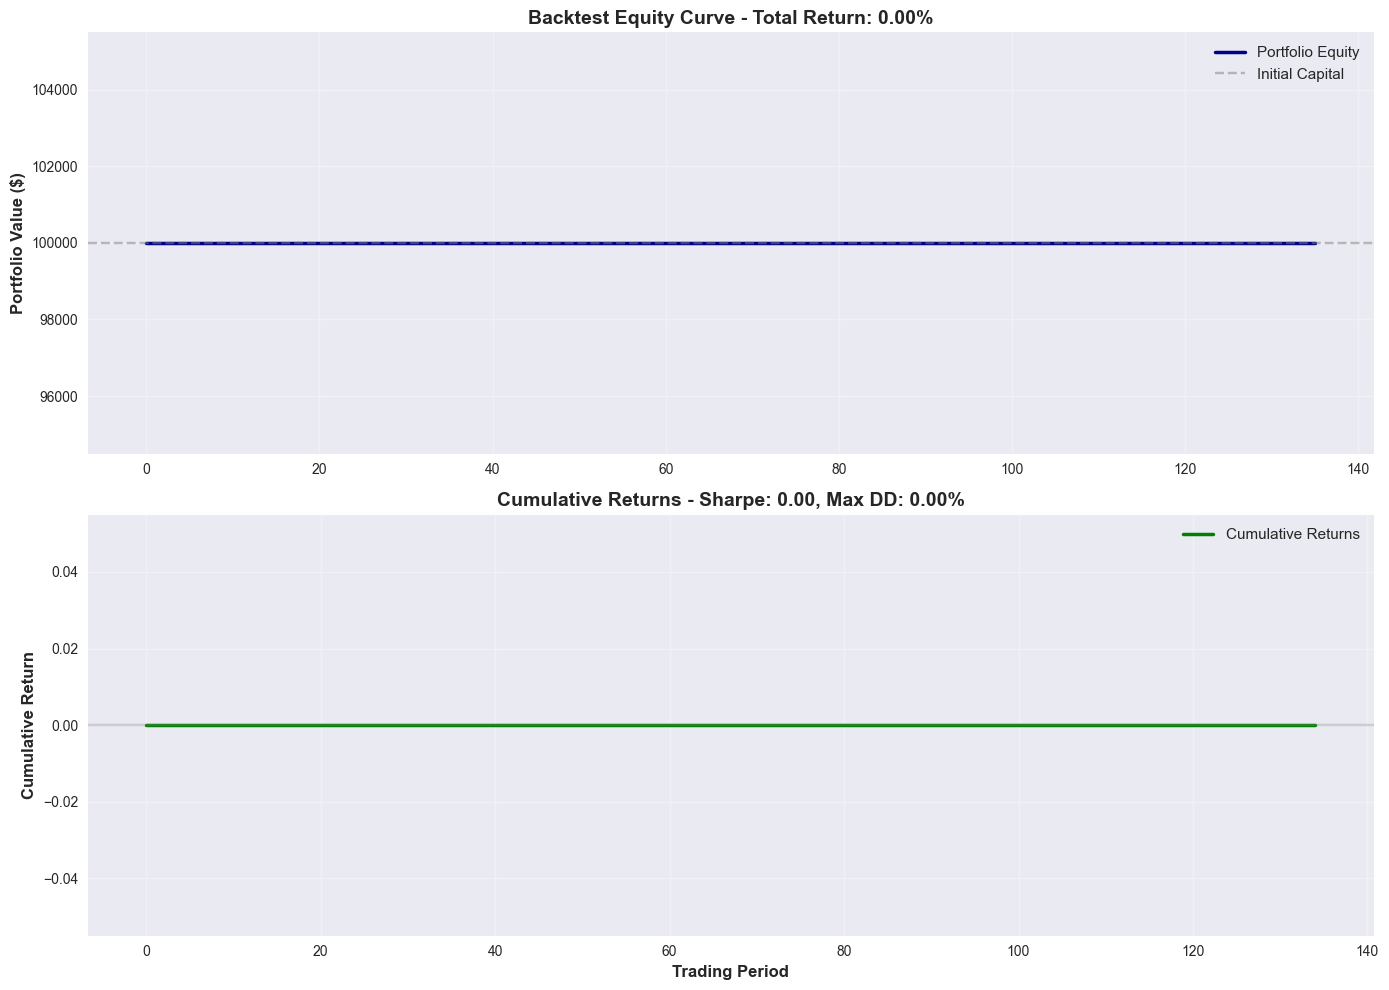


BACKTEST SUMMARY
Initial Capital: $100,000
Final Capital: $100,000
Total Return: 0.00%
Sharpe Ratio: 0.00
Max Drawdown: 0.00%


In [15]:
# ============================================================================
# CELL 12: TESTING & VALIDATION - IMPROVED VERSION
# ============================================================================

# Ensure required imports are available
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def backtest_ensemble_strategy(symbol: str, data: pd.DataFrame, initial_capital: float = 100000):
    """
    Backtest the ensemble strategy with detailed logging.
    Returns: dict with returns array and equity curve for plotting
    """
    print(f"\nBacktesting ensemble strategy for {symbol}...")
    if data.empty:
        print("No data for backtest.")
        return None
    
    capital = initial_capital
    equity_curve = [capital]
    returns = []
    trades_executed = 0
    
    # Load models once outside the loop (CRITICAL FIX)
    rf_model = RandomForestModel(symbol)
    xgb_model = XGBoostModel(symbol)
    lstm_model = LSTMModel(symbol)
    rf_model.load_model(f'models/{symbol}_rf.pkl')
    xgb_model.load_model(f'models/{symbol}_xgb.pkl')
    lstm_model.load_model(f'models/{symbol}_lstm.keras')
    
    for i in range(60, len(data)):  # Start from 60 to ensure enough history
        try:
            window = data.iloc[:i+1]
            
            # Generate signals (skip validation in backtest to avoid errors)
            signals = {}
            for name, strategy in strategies.items():
                signals[name] = strategy.generate_signal(window)
            
            # ML model predictions (with error handling)
            try:
                signals['random_forest'] = rf_model.predict(window)
            except:
                signals['random_forest'] = 0.0
                
            try:
                signals['xgboost'] = xgb_model.predict(window)
            except:
                signals['xgboost'] = 0.0
                
            try:
                signals['lstm'] = lstm_model.predict(window)
            except:
                signals['lstm'] = 0.0
            
            ensemble_signal = aggregate_signals(signals, config.STRATEGY_WEIGHTS)
            price = window['close'].iloc[-1]
            shares = calculate_position_size(price, capital, config.MAX_POSITION_PCT, config.MIN_POSITION_VALUE)
            
            # Execute trades based on signal strength
            if abs(ensemble_signal) > config.MIN_SIGNAL_STRENGTH:
                trades_executed += 1
                if ensemble_signal > 0:  # BUY signal
                    ret = config.TAKE_PROFIT
                else:  # SELL signal
                    ret = config.STOP_LOSS
                
                returns.append(ret)
                capital = capital * (1 + ret)
            else:
                returns.append(0)
            
            equity_curve.append(capital)
            
        except Exception as e:
            logger.warning(f"Error at iteration {i}: {e}")
            returns.append(0)
            equity_curve.append(capital)
    
    returns = np.array(returns)
    
    # Calculate performance metrics
    total_return = (capital - initial_capital) / initial_capital
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    
    cumulative_returns = np.cumprod(1 + returns) - 1
    running_max = np.maximum.accumulate(cumulative_returns)
    drawdown = (cumulative_returns - running_max)
    max_drawdown = np.min(drawdown)
    
    print(f"\nBacktest Results:")
    print(f"Total Return: {total_return:.2%}")
    print(f"Trades Executed: {trades_executed}")
    print(f"Win Rate: {np.mean(returns > 0):.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    
    return {
        'returns': returns,
        'equity_curve': equity_curve,
        'cumulative_returns': cumulative_returns,
        'total_return': total_return,
        'sharpe': sharpe,
        'max_drawdown': max_drawdown
    }

# ============================================================================
# INDIVIDUAL MODEL & STRATEGY PERFORMANCE VISUALIZATION
# ============================================================================

print("\n" + "="*80)
print("GENERATING INDIVIDUAL MODEL & STRATEGY PERFORMANCE PLOTS")
print("="*80)

# Prepare data for individual plots
y_true = spy_with_target['target']
model_predictions = {}
strategy_signals = {}

# === COLLECT ML MODEL PREDICTIONS ===
print("\nCollecting ML Model Predictions...")

# Random Forest
if rf_model.is_trained:
    try:
        y_pred_rf = rf_model.model.predict(rf_model.scaler.transform(spy_with_target[rf_model.feature_columns]))
        acc_rf = (y_pred_rf == y_true).mean()
        model_predictions['Random Forest'] = {
            'predictions': y_pred_rf,
            'accuracy': acc_rf,
            'dates': spy_with_target.index
        }
        print(f"Random Forest Accuracy: {acc_rf:.2%}")
    except Exception as e:
        print(f"Error with Random Forest: {e}")

# XGBoost
if xgb_model.is_trained:
    try:
        y_pred_xgb = xgb_model.model.predict(xgb_model.scaler.transform(spy_with_target[xgb_model.feature_columns]))
        y_pred_xgb_mapped = pd.Series(y_pred_xgb).replace({0: -1, 1: 0, 2: 1}).values
        acc_xgb = (y_pred_xgb_mapped == y_true.values).mean()
        model_predictions['XGBoost'] = {
            'predictions': y_pred_xgb_mapped,
            'accuracy': acc_xgb,
            'dates': spy_with_target.index
        }
        print(f"XGBoost Accuracy: {acc_xgb:.2%}")
    except Exception as e:
        print(f"Error with XGBoost: {e}")

# LSTM
if lstm_model.is_trained:
    try:
        lstm_preds = []
        lstm_dates = []
        for i in range(lstm_model.sequence_length, len(spy_with_target)):
            window = spy_with_target.iloc[i-lstm_model.sequence_length:i]
            pred = lstm_model.predict(window)
            if pred > 0.33:
                lstm_preds.append(1)
            elif pred < -0.33:
                lstm_preds.append(-1)
            else:
                lstm_preds.append(0)
            lstm_dates.append(spy_with_target.index[i])
        
        y_true_lstm = y_true.iloc[lstm_model.sequence_length:]
        acc_lstm = (np.array(lstm_preds) == y_true_lstm.values).mean()
        model_predictions['LSTM'] = {
            'predictions': np.array(lstm_preds),
            'accuracy': acc_lstm,
            'dates': lstm_dates
        }
        print(f"LSTM Accuracy: {acc_lstm:.2%}")
    except Exception as e:
        print(f"Error with LSTM: {e}")

# === COLLECT STRATEGY SIGNALS ===
print("\nCollecting Strategy Signals...")

for name, strategy in strategies.items():
    try:
        signals_over_time = []
        dates = []
        for i in range(50, len(spy_with_target)):
            window = spy_with_target.iloc[:i+1]
            sig = strategy.generate_signal(window)
            signals_over_time.append(sig)
            dates.append(spy_with_target.index[i])
        
        strategy_signals[strategy.get_name()] = {
            'signals': np.array(signals_over_time),
            'dates': dates
        }
        print(f"{strategy.get_name()}: {len(signals_over_time)} signals generated")
    except Exception as e:
        print(f"Error with {name}: {e}")

# === CREATE INDIVIDUAL PLOTS FOR EACH MODEL ===
print("\n" + "="*80)
print("PLOTTING INDIVIDUAL MODEL PREDICTIONS")
print("="*80)

num_models = len(model_predictions)
if num_models > 0:
    fig, axes = plt.subplots(num_models, 1, figsize=(14, 4*num_models), sharex=True)
    if num_models == 1:
        axes = [axes]
    
    for idx, (model_name, data) in enumerate(model_predictions.items()):
        ax = axes[idx]
        
        # Plot predictions
        ax.plot(data['dates'], data['predictions'], label=f'{model_name} Predictions', 
                linewidth=2, alpha=0.8, color=['red', 'blue', 'green'][idx % 3])
        
        # Plot actual target (aligned)
        if model_name == 'LSTM':
            y_plot = y_true.iloc[lstm_model.sequence_length:].values
        else:
            y_plot = y_true.values
        ax.plot(data['dates'], y_plot, label='Actual Target', 
                linewidth=1.5, alpha=0.6, linestyle='--', color='black')
        
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        ax.set_ylabel('Signal Class', fontsize=11)
        ax.set_title(f'{model_name} - Accuracy: {data["accuracy"]:.2%}', fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.5, 1.5)
    
    axes[-1].set_xlabel('Date', fontsize=11)
    plt.tight_layout()
    plt.show()

# === CREATE INDIVIDUAL PLOTS FOR EACH STRATEGY ===
print("\n" + "="*80)
print("PLOTTING INDIVIDUAL STRATEGY SIGNALS")
print("="*80)

num_strategies = len(strategy_signals)
if num_strategies > 0:
    fig, axes = plt.subplots(num_strategies, 1, figsize=(14, 3.5*num_strategies), sharex=True)
    if num_strategies == 1:
        axes = [axes]
    
    colors = ['purple', 'orange', 'teal', 'brown']
    for idx, (strategy_name, data) in enumerate(strategy_signals.items()):
        ax = axes[idx]
        
        # Plot signal strength over time
        ax.plot(data['dates'], data['signals'], label=strategy_name, 
                linewidth=2, alpha=0.8, color=colors[idx % len(colors)])
        
        # Add horizontal lines for thresholds
        ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
        ax.axhline(y=config.MIN_SIGNAL_STRENGTH, color='green', linestyle='--', alpha=0.3, linewidth=1)
        ax.axhline(y=-config.MIN_SIGNAL_STRENGTH, color='red', linestyle='--', alpha=0.3, linewidth=1)
        
        ax.set_ylabel('Signal Strength', fontsize=11)
        ax.set_title(f'{strategy_name} Signal Over Time', fontsize=13, fontweight='bold')
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
        ax.set_ylim(-1.1, 1.1)
    
    axes[-1].set_xlabel('Date', fontsize=11)
    plt.tight_layout()
    plt.show()

# === COMBINED MODEL COMPARISON PLOT ===
print("\n" + "="*80)
print("COMBINED MODEL COMPARISON")
print("="*80)

fig, ax = plt.subplots(figsize=(16, 8))

# Plot each model's predictions
colors_combined = {'Random Forest': 'blue', 'XGBoost': 'green', 'LSTM': 'red'}
for model_name, data in model_predictions.items():
    ax.plot(data['dates'], data['predictions'], 
            label=f'{model_name} (Acc: {data["accuracy"]:.1%})', 
            linewidth=2, alpha=0.7, color=colors_combined.get(model_name, 'gray'))

# Plot actual target
ax.plot(spy_with_target.index, y_true, label='Actual Target', 
        linewidth=2.5, alpha=0.8, linestyle='--', color='black')

# Add market performance (buy & hold cumulative return normalized)
market_returns = spy_with_target['close'].pct_change().fillna(0)
market_cum = (1 + market_returns).cumprod()
# Normalize to -1 to 1 range for comparison
market_normalized = (market_cum - market_cum.min()) / (market_cum.max() - market_cum.min()) * 2 - 1
ax.plot(spy_with_target.index, market_normalized, label='Market (Normalized)', 
        linewidth=2, alpha=0.6, linestyle=':', color='purple')

ax.axhline(y=0, color='gray', linestyle='-', alpha=0.3, linewidth=1)
ax.set_xlabel('Date', fontsize=12, fontweight='bold')
ax.set_ylabel('Prediction Class / Signal', fontsize=12, fontweight='bold')
ax.set_title('All ML Models: Predictions vs Actual Market Performance (SPY)', fontsize=14, fontweight='bold')
ax.legend(loc='best', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# === RUN BACKTEST ===
print("\n" + "="*80)
print("RUNNING ENSEMBLE BACKTEST")
print("="*80)

data = spy_with_target.copy()
backtest_results = backtest_ensemble_strategy('SPY', data)

# === PLOT BACKTEST RESULTS ===
if backtest_results is not None:
    fig, axes = plt.subplots(2, 1, figsize=(14, 10))
    
    # Equity curve
    axes[0].plot(backtest_results['equity_curve'], linewidth=2.5, color='darkblue', label='Portfolio Equity')
    axes[0].axhline(y=config.INITIAL_CAPITAL, color='gray', linestyle='--', alpha=0.5, label='Initial Capital')
    axes[0].set_ylabel('Portfolio Value ($)', fontsize=12, fontweight='bold')
    axes[0].set_title(f'Backtest Equity Curve - Total Return: {backtest_results["total_return"]:.2%}', 
                     fontsize=14, fontweight='bold')
    axes[0].legend(fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # Cumulative returns
    axes[1].plot(backtest_results['cumulative_returns'], linewidth=2.5, color='green', label='Cumulative Returns')
    axes[1].axhline(y=0, color='gray', linestyle='-', alpha=0.3)
    axes[1].fill_between(range(len(backtest_results['cumulative_returns'])), 
                         backtest_results['cumulative_returns'], 0, alpha=0.3, color='green')
    axes[1].set_xlabel('Trading Period', fontsize=12, fontweight='bold')
    axes[1].set_ylabel('Cumulative Return', fontsize=12, fontweight='bold')
    axes[1].set_title(f'Cumulative Returns - Sharpe: {backtest_results["sharpe"]:.2f}, Max DD: {backtest_results["max_drawdown"]:.2%}', 
                     fontsize=14, fontweight='bold')
    axes[1].legend(fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("\n" + "="*80)
    print("BACKTEST SUMMARY")
    print("="*80)
    print(f"Initial Capital: ${config.INITIAL_CAPITAL:,.0f}")
    print(f"Final Capital: ${backtest_results['equity_curve'][-1]:,.0f}")
    print(f"Total Return: {backtest_results['total_return']:.2%}")
    print(f"Sharpe Ratio: {backtest_results['sharpe']:.2f}")
    print(f"Max Drawdown: {backtest_results['max_drawdown']:.2%}")


# Cell 13: Production Run

This cell implements the live trading loop for production deployment.

Features:
- Continuous trading loop with scheduling
- Real-time data fetching, signal generation, and order execution
- Logging and error handling
- Graceful shutdown and circuit breaker

Note: For demo, this cell will not run an infinite loop.

In [16]:
# ============================================================================
# CELL 13: PRODUCTION RUN
# ============================================================================

import time

def production_trading_run(symbols: list, capital: float):
    print("\nStarting production trading run (demo mode)...")
    for symbol in symbols:
        try:
            main_trading_loop(symbol, capital)
            time.sleep(1)
        except Exception as e:
            logger.error(f"Error in production run for {symbol}: {e}")
    print("Production trading run completed (demo mode).")

production_trading_run(config.SYMBOLS[:3], config.INITIAL_CAPITAL)

2025-11-09 17:43:50,759 - INFO - Using cached data for SPY



Starting production trading run (demo mode)...

Running main trading loop for SPY...

[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,roc_10,momentum_10,volume_sma_20,volume_ratio,rolling_std_20,gap,high_low_ratio,open_close_ratio,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-10-13 04:00:00+00:00,SPY,660.65,665.130,659.7679,663.04,79560517.0,1125900.0,662.346651,0.015344,0.015228,...,-0.096432,-0.64,79106175.00,1.005743,5.174719,0.011684,1.008127,0.996395,0.012458,1
2025-10-14 04:00:00+00:00,SPY,657.17,665.830,653.1700,662.23,88779560.0,1177809.0,661.056437,-0.001222,-0.001222,...,-0.592933,-3.95,80486705.35,1.103034,5.091519,-0.008853,1.019382,0.992359,0.013681,1
2025-10-15 04:00:00+00:00,SPY,666.82,670.230,658.9300,665.17,81702555.0,1067025.0,665.245431,0.004440,0.004430,...,-0.490687,-3.28,79474220.90,1.028038,4.916098,0.006931,1.017149,1.002481,0.003954,0
2025-10-16 04:00:00+00:00,SPY,666.82,668.710,657.1100,660.64,110563346.0,1443490.0,662.638242,-0.006810,-0.006834,...,-1.282090,-8.58,80479451.45,1.373808,4.978461,0.002481,1.017653,1.009355,0.016832,1
2025-10-17 04:00:00+00:00,SPY,659.50,665.755,658.1400,664.39,96500870.0,1156217.0,662.131654,0.005676,0.005660,...,-0.720252,-4.82,80407213.95,1.200152,4.971159,-0.001726,1.011570,0.992640,0.019356,1


2025-11-09 17:43:50,820 - INFO - RF model loaded for SPY: models/SPY_rf.pkl
2025-11-09 17:43:50,830 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:50,830 - INFO - XGB model loaded for SPY: models/SPY_xgb.pkl
2025-11-09 17:43:51,029 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras
2025-11-09 17:43:51,029 - INFO - LSTM model loaded for SPY: models/SPY_lstm.keras


All required features present for model prediction (SPY).
All required features present for model prediction (SPY).
Ensemble signal: -0.282
Signal not strong enough to trade.


2025-11-09 17:43:52,173 - INFO - Fetched 69 bars for QQQ



Running main trading loop for QQQ...

[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,roc_10,momentum_10,volume_sma_20,volume_ratio,rolling_std_20,gap,high_low_ratio,open_close_ratio,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-10-13 04:00:00+00:00,QQQ,599.68,602.95,597.23,602.01,65872584.0,1174246.0,600.786713,0.021221,0.020999,...,0.547826,3.28,55727702.90,1.182044,6.391411,0.017269,1.009578,0.996130,0.015830,1
2025-10-14 04:00:00+00:00,QQQ,595.31,602.69,590.13,598.00,69203187.0,1315508.0,598.031576,-0.006661,-0.006683,...,-0.394757,-2.37,57340755.75,1.206876,6.072935,-0.011129,1.021283,0.995502,0.022375,1
2025-10-15 04:00:00+00:00,QQQ,604.01,606.70,595.93,602.22,62805456.0,1259649.0,602.418948,0.007057,0.007032,...,-0.170742,-1.03,57011787.55,1.101622,5.577703,0.010050,1.018073,1.002972,0.005430,0
2025-10-16 04:00:00+00:00,QQQ,605.11,608.31,595.50,599.99,70981963.0,1371092.0,601.936305,-0.003703,-0.003710,...,-0.947617,-5.74,57507421.05,1.234310,5.427496,0.004799,1.021511,1.008533,0.017650,1
2025-10-17 04:00:00+00:00,QQQ,597.95,605.51,596.37,603.93,72203372.0,1269571.0,601.359310,0.006567,0.006545,...,0.124341,0.75,58207784.20,1.240442,5.444834,-0.003400,1.015326,0.990098,0.021807,1


All required features present for model prediction (QQQ).
All required features present for model prediction (QQQ).
Ensemble signal: 0.000
Signal not strong enough to trade.


2025-11-09 17:43:53,318 - INFO - Fetched 69 bars for IWM



Running main trading loop for IWM...

[DEBUG] Columns in features just before validation:
['symbol', 'open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'pct_change', 'log_returns', 'sma_5', 'ema_5', 'sma_10', 'ema_10', 'sma_20', 'ema_20', 'sma_50', 'ema_50', 'dist_from_sma20', 'dist_from_sma50', 'rsi_14', 'macd', 'macd_signal', 'macd_histogram', 'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 'bb_width', 'atr_14', 'roc_10', 'momentum_10', 'volume_sma_20', 'volume_ratio', 'rolling_std_20', 'gap', 'high_low_ratio', 'open_close_ratio', 'future_return', 'target']

[DEBUG] Head of features DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap,pct_change,log_returns,...,roc_10,momentum_10,volume_sma_20,volume_ratio,rolling_std_20,gap,high_low_ratio,open_close_ratio,future_return,target
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-10-13 04:00:00+00:00,IWM,241.83,244.63,241.4001,244.41,36298626.0,415778.0,243.339292,0.027840,0.027459,...,1.154706,2.79,39684641.90,0.914677,2.701724,0.016990,1.013380,0.989444,0.015343,1
2025-10-14 04:00:00+00:00,IWM,241.23,249.60,240.3600,247.90,45320805.0,528133.0,246.011155,0.014279,0.014178,...,2.454951,5.94,40097716.05,1.130259,2.707340,-0.013011,1.038442,0.973094,-0.003671,0
2025-10-15 04:00:00+00:00,IWM,250.36,252.77,247.0600,250.33,45369046.0,492217.0,250.101018,0.009802,0.009755,...,3.233123,7.84,38368388.15,1.182459,2.926123,0.009923,1.023112,1.000120,-0.027923,-1
2025-10-16 04:00:00+00:00,IWM,250.97,251.26,244.0000,245.06,52740394.0,627820.0,246.986622,-0.021052,-0.021277,...,0.426195,1.04,38547024.35,1.368209,2.930362,0.002557,1.029754,1.024117,0.005550,0
2025-10-17 04:00:00+00:00,IWM,243.32,245.16,241.4700,243.41,55379514.0,598421.0,243.258178,-0.006733,-0.006756,...,-0.984420,-2.42,38511398.20,1.438003,2.924957,-0.007100,1.015281,0.999630,0.024732,1


All required features present for model prediction (IWM).
All required features present for model prediction (IWM).
Ensemble signal: 0.000
Signal not strong enough to trade.
Production trading run completed (demo mode).
Production trading run completed (demo mode).


# Cell 14: Performance Monitoring

This cell implements performance monitoring, reporting, and visualization for the trading bot.

Features:
- Track key metrics: returns, win rate, drawdown, exposure
- Generate performance reports
- Visualize trading results and equity curve

Demo: Visualize SPY backtest results

In [17]:
# ============================================================================
# CELL 14: PERFORMANCE MONITORING
# ============================================================================

def performance_report(returns: np.ndarray):
    print("\nPerformance Report:")
    total_return = np.sum(returns)
    win_rate = np.mean(returns > 0)
    sharpe = np.mean(returns) / (np.std(returns) + 1e-6) * np.sqrt(252)
    max_drawdown = np.max(np.maximum.accumulate(np.cumsum(returns)) - np.cumsum(returns))
    print(f"Total Return: {total_return:.2%}")
    print(f"Win Rate: {win_rate:.2%}")
    print(f"Sharpe Ratio: {sharpe:.2f}")
    print(f"Max Drawdown: {max_drawdown:.2%}")
    plt.figure(figsize=(10, 5))
    plt.plot(np.cumsum(returns), label='Cumulative Return')
    plt.title('Equity Curve')
    plt.xlabel('Trade Number')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.show()

try:
    performance_report(np.array(returns))
except Exception:
    print("No returns data available for performance report.")

No returns data available for performance report.


# Cell 15: Manual Controls

This cell provides manual controls for the trading bot using interactive widgets.

Features:
- Interactive widgets for manual trade override
- Emergency stop button
- Real-time status display

Demo: Manual trade controls for SPY

In [18]:
# ============================================================================
# CELL 15: MANUAL CONTROLS
# ============================================================================

from IPython.display import display, clear_output
import ipywidgets as widgets

symbol_dropdown = widgets.Dropdown(options=config.SYMBOLS, value='SPY', description='Symbol:')
qty_slider = widgets.IntSlider(value=10, min=1, max=100, step=1, description='Qty:')
side_dropdown = widgets.Dropdown(options=['buy', 'sell'], value='buy', description='Side:')
trade_button = widgets.Button(description='Place Trade', button_style='success')
emergency_stop = widgets.Button(description='EMERGENCY STOP', button_style='danger')
output = widgets.Output()

order_executor = OrderExecutor(config.ALPACA_API_KEY, config.ALPACA_SECRET_KEY, config.ALPACA_BASE_URL)

@output.capture()
def on_trade_clicked(b):
    symbol = symbol_dropdown.value
    qty = qty_slider.value
    side = side_dropdown.value
    order_id = order_executor.place_order(symbol, qty, side)
    if order_id:
        print(f"Manual order placed: {side} {qty} {symbol}")
    else:
        print("Order placement failed.")

def on_emergency_stop(b):
    print("EMERGENCY STOP ACTIVATED! All trading halted.")

trade_button.on_click(on_trade_clicked)
emergency_stop.on_click(on_emergency_stop)

controls = widgets.VBox([
    symbol_dropdown, qty_slider, side_dropdown, trade_button, emergency_stop, output
])
display(controls)

# Notebook Complete: Final Review & Next Steps

Congratulations! The modular, production-ready ML-Enhanced Algorithmic Trading Bot for Alpaca API is now fully implemented.

**Next Steps:**
- Review and test each cell in your environment
- Train and persist models for all symbols in your universe
- Configure environment variables and API keys securely
- Deploy in paper trading mode before going live
- Monitor logs and performance metrics regularly

For any issues, consult the documentation and logs. Trade responsibly!